#Import of Required Libraries

In [ ]:
from google.colab import drive
import pandas as pd
import datetime as dt
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


________________________________________________________________________________

#Initial Code Blocks (Trial & Errors)

In [ ]:
# Adjust file path construction based on the updated file name format
month = '2208'  # Example month
excess_inventory_filepath = '/content/drive/My Drive/Project Raw Data/Excess Inventory Purchase.xlsx'
demand_data_filepath = f'/content/drive/My Drive/Project Raw Data/Demand/{month} Demand.xlsx'
part_data_filepath = f'/content/drive/My Drive/Project Raw Data/LT Data/{month} Part data.xlsx'

# Load the Excess Inventory file
Inv_df = pd.read_excel(excess_inventory_filepath)

# Load the Demand and Part data files for the current month
# Read the Excel file with converters
Demand_df = pd.read_excel(demand_data_filepath, converters={'Due Date': lambda x: pd.to_datetime('1900-01-01') if x == 'Past' else x})
LTP_df = pd.read_excel(part_data_filepath)

# List of columns to remove from Inv_df
columns_to_remove = ['Status', 'EMS Part Number',
                 'Description', 'Supplier Name', 'EMS comments', 'Reason for MOQ Excess Request',
                 'TER/EMS Sister Site Stock', 'Add the req qty to existing open PO?',
                 'Open Market checked?', 'Got quotes from Suppliers?', 'Task Owner', 'TER comments',
                 'Manufacturer name', 'TER safety stock', 'Excess Inventory WF', 'EMS total excess',
                 'Modified', 'Div', 'Management Hold', 'ClosedDate', 'Aging']

# Drop the specified columns from Inv_df
Inv_df.drop(columns=columns_to_remove, inplace=True)

# Extract only the required columns from LTP_df
LTP_df_filtered = LTP_df[['Site', 'TER Part Number', 'cum lt wks']]

# Copy the required columns
Demand_filtered = Demand_df[['TER Part Number', 'Site', 'Due Date', 'Planned Demand', 'Parent site', 'Parent part']].copy()

# Display the dataframes
Inv_df.head(), Demand_filtered.head(), LTP_df_filtered.head()

(   Request ID          EMS Requested date  Quantity ordered   MOQ  Site  \
 0  PLEX-10509       PLEXUS     2023-12-19                 5     5  PLXP   
 1  PLEX-10505       PLEXUS     2023-12-19                48    48  PLXP   
 2  PLEX-10501       PLEXUS     2023-12-14              3000  3000  PLXP   
 3   FLEX-5377  FLEXTRONICS     2023-12-14              1000  1000  FLPT   
 4  PLEX-10494       PLEXUS     2023-12-14                50    50  PLXP   
 
   TER Part Number  TER Agreed to Price  EMS Agreed to Price  PO Price  \
 0        CBL0840G             157.2100             157.2100  157.2100   
 1        ACT0775G               2.0990               2.0990   17.9000   
 2          515659               0.3984               0.3984    0.3175   
 3      5461842600               5.2600               5.2600    5.2600   
 4          512478              23.1300              23.1300   29.7000   
 
    12 months materials excess  12 months materials excess ($)  \
 0                           4

In [ ]:
# Define the year and month for filtering
year = 2022  # Example year
month_num = 8  # Example month

# Filter the Inv_df based on the requested date within the needed date frame
last_day = pd.Timestamp(year=year, month=month_num, day=1) + pd.offsets.MonthEnd(1)
start_date = pd.Timestamp(year=year, month=month_num, day=1)
end_date = last_day
Inv_df_filtered = Inv_df[(Inv_df['Requested date'] >= start_date) & (Inv_df['Requested date'] <= end_date)]

# Display the filtered dataframe
print(Inv_df_filtered.head())

     Request ID          EMS Requested date  Quantity ordered   MOQ  Site  \
1345  FLEX-4147  FLEXTRONICS     2022-08-03              7000  3500  SLRS   
1346  FLEX-4156  FLEXTRONICS     2022-08-10                10    10  FLPT   
1347  FLEX-4157  FLEXTRONICS     2022-08-10                10    10  FLPT   
1348  FLEX-4160  FLEXTRONICS     2022-08-12               280   280  SLRS   
1349  FLEX-4161  FLEXTRONICS     2022-08-12                60    60  SLRS   

     TER Part Number  TER Agreed to Price  EMS Agreed to Price  PO Price  \
1345      710-036-00                 0.20                 0.20      0.45   
1346      979-251-01              2595.02              2595.02   3236.49   
1347      979-543-00              2073.93              2073.93   2666.03   
1348      356-029-04                19.09                19.09     19.09   
1349      438-025-00               204.20               204.20    204.20   

      12 months materials excess  12 months materials excess ($)  \
1345        

In [ ]:
# Perform a merge operation to align rows based on 'Site' and 'TER Part Number'
merged_df = pd.merge(Inv_df_filtered, LTP_df_filtered, on=['Site', 'TER Part Number'])

# Calculate 'LT (days)' based on 'cum lt wks' from the merged DataFrame
merged_df['LT (days)'] = (merged_df['cum lt wks'] * 2 ) * 7  # Multiplies cumulative lead weeks by 2, then converts to days

# Convert 'LT (days)' to a timedelta, then calculate the 'Adjusted date'
merged_df['LT (days)'] = pd.to_timedelta(merged_df['LT (days)'], unit='D')
merged_df['Adjusted date'] = merged_df['Requested date'] + merged_df['LT (days)']

# Calculate the difference in days
merged_df['Difference (days)'] = (merged_df['Adjusted date'] - merged_df['Requested date']).dt.days

# Apply the conditions to adjust 'LT (days)' based on the difference
conditions = [
    (merged_df['Difference (days)'] < 182),
    (merged_df['Difference (days)'] >= 182) & (merged_df['Difference (days)'] <= 365),
    (merged_df['Difference (days)'] > 365)
]
choices = [
    pd.to_timedelta(182, unit='D'),  # Set to 182 days
    merged_df['LT (days)'],  # Keep as is
    pd.to_timedelta(365, unit='D')  # Set to 365 days
]

merged_df['New LT (days)'] = pd.to_timedelta(np.select(conditions, choices, default=merged_df['LT (days)']))

# Recalculate the 'New Adjusted date' based on the updated 'New LT (days)'
merged_df['New Adjusted date'] = merged_df['Requested date'] + merged_df['New LT (days)']
merged_df['New Adjusted date'] = merged_df['New Adjusted date'].dt.date

# Convert 'New Adjusted date' and 'Requested date' to datetime.date objects for consistency
merged_df['Adjusted date'] = pd.to_datetime(merged_df['Adjusted date']).dt.date
merged_df['New Adjusted date'] = pd.to_datetime(merged_df['New Adjusted date']).dt.date
merged_df['Requested date'] = pd.to_datetime(merged_df['Requested date']).dt.date

# Convert 'LT (days)' and 'New LT (days)' to days only
merged_df['LT (days)'] = merged_df['LT (days)'].dt.days
merged_df['New LT (days)'] = merged_df['New LT (days)'].dt.days

# Print the filtered DataFrame
print(merged_df.head())

  Request ID          EMS Requested date  Quantity ordered   MOQ  Site  \
0  FLEX-4147  FLEXTRONICS     2022-08-03              7000  3500  SLRS   
1  FLEX-4178  FLEXTRONICS     2022-08-19               760  3500  SLRS   
2  FLEX-4156  FLEXTRONICS     2022-08-10                10    10  FLPT   
3  FLEX-4157  FLEXTRONICS     2022-08-10                10    10  FLPT   
4  FLEX-4160  FLEXTRONICS     2022-08-12               280   280  SLRS   

  TER Part Number  TER Agreed to Price  EMS Agreed to Price  PO Price  ...  \
0      710-036-00                 0.20                 0.20      0.45  ...   
1      710-036-00                 0.20                 0.20      0.20  ...   
2      979-251-01              2595.02              2595.02   3236.49  ...   
3      979-543-00              2073.93              2073.93   2666.03  ...   
4      356-029-04                19.09                19.09     19.09  ...   

   Open order  Actual need quantity        Shortage date  \
0       66500             

In [ ]:
# Merge Demand_filtered and merged_df
final_merge = pd.merge(Demand_filtered,
                       merged_df[['Site', 'TER Part Number', 'Request ID', 'Requested date', 'New Adjusted date', 'Adjusted date', 'OH', 'Open order', 'Quantity ordered','PO Price']],
                       on=['Site', 'TER Part Number'],
                       how='inner')

print(final_merge.head())

  TER Part Number  Site   Due Date  Planned Demand Parent site   Parent part  \
0      232-052-00  SLRS 1900-01-01             0.0         NaN           NaN   
1      232-052-00  SLRS 2022-07-27             1.0        SLRS  239-052-03-M   
2      232-052-00  SLRS 2022-08-23             6.0        SLRS  239-052-03-M   
3      232-052-00  SLRS 2022-10-01             5.0        SLRS  239-052-03-M   
4      232-052-00  SLRS 2022-10-15             4.0        SLRS  239-052-03-M   

  Request ID Requested date New Adjusted date Adjusted date  OH  Open order  \
0  FLEX-4193     2022-08-25        2023-03-17    2023-03-17  22           0   
1  FLEX-4193     2022-08-25        2023-03-17    2023-03-17  22           0   
2  FLEX-4193     2022-08-25        2023-03-17    2023-03-17  22           0   
3  FLEX-4193     2022-08-25        2023-03-17    2023-03-17  22           0   
4  FLEX-4193     2022-08-25        2023-03-17    2023-03-17  22           0   

   Quantity ordered  PO Price  
0           

In [ ]:
# Step 1: Convert Date Columns to Datetime
final_merge['Due Date'] = pd.to_datetime(final_merge['Due Date'])
final_merge['New Adjusted date'] = pd.to_datetime(final_merge['New Adjusted date'])

print(final_merge.head())

  TER Part Number  Site   Due Date  Planned Demand Parent site   Parent part  \
0      232-052-00  SLRS 1900-01-01             0.0         NaN           NaN   
1      232-052-00  SLRS 2022-07-27             1.0        SLRS  239-052-03-M   
2      232-052-00  SLRS 2022-08-23             6.0        SLRS  239-052-03-M   
3      232-052-00  SLRS 2022-10-01             5.0        SLRS  239-052-03-M   
4      232-052-00  SLRS 2022-10-15             4.0        SLRS  239-052-03-M   

  Request ID Requested date New Adjusted date Adjusted date  OH  Open order  \
0  FLEX-4193     2022-08-25        2023-03-17    2023-03-17  22           0   
1  FLEX-4193     2022-08-25        2023-03-17    2023-03-17  22           0   
2  FLEX-4193     2022-08-25        2023-03-17    2023-03-17  22           0   
3  FLEX-4193     2022-08-25        2023-03-17    2023-03-17  22           0   
4  FLEX-4193     2022-08-25        2023-03-17    2023-03-17  22           0   

   Quantity ordered  PO Price  
0           

In [ ]:
# Step 3: Filtering
filtered_data = final_merge[(final_merge['Due Date'] < final_merge['New Adjusted date']) | (final_merge['Due Date'] == pd.to_datetime('1900-01-01'))]

# Group by 'Site', 'TER Part Number', 'Request ID', and 'Requested date' to sum 'Planned Demand'
Monthly_demand = filtered_data.groupby(['Site', 'TER Part Number', 'Request ID', 'Requested date']).agg({'Planned Demand': 'sum'}).reset_index()

# Select relevant columns from merged_df
Monthly_Excess = pd.merge(Demand_filtered,
                       merged_df[['Site', 'TER Part Number', 'Request ID', 'Requested date', 'OH', 'Open order', 'Quantity ordered', 'PO Price']],
                       on=['Site', 'TER Part Number'],
                       how='inner')

# Group by 'TER Part Number', 'Site', 'Request ID', and 'Requested date' without aggregation
Monthly_Excess = Monthly_Excess.groupby(['TER Part Number', 'Site', 'Request ID', 'Requested date']).agg({
    'OH': lambda x: x.iloc[0],  # Take the first value of 'OH'
    'Open order': lambda x: x.iloc[0],  # Take the first value of 'Open order'
    'Quantity ordered': lambda x: x.iloc[0],  # Take the first value of 'Quantity ordered'
    'PO Price': 'first',  # Assuming 'PO Price' is constant for each unique combination
    'Parent part': 'first',  # Take the first value of 'Parent part'
    'Parent site': 'first'  # Take the first value of 'Parent site'
}).reset_index()

# Merge Monthly_Excess with Monthly_demand to include 'Planned Demand'
Monthly_excess = pd.merge(Monthly_Excess, Monthly_demand, on=['TER Part Number', 'Site', 'Request ID', 'Requested date'], how='left')

# Calculate Suggested Actual Need
Monthly_excess['Suggested_Need_Quantity'] = Monthly_excess['Planned Demand'] - Monthly_excess['OH'] - Monthly_excess['Open order']

#Monthly_excess['Suggested_Need_Quantity'] = Monthly_excess['Suggested_Need_Quantity'].clip(lower=0)

# Calculate Potential Excess Inventory with Proposed LT Demand
Monthly_excess['Potential_Excess_Inventory'] = Monthly_excess['Quantity ordered'] - Monthly_excess['Suggested_Need_Quantity']

#Monthly_excess['Potential_Excess_Inventory'] = Monthly_excess['Potential_Excess_Inventory'].clip(lower=0)

print(Monthly_excess.head())

  TER Part Number  Site Request ID Requested date     OH  Open order  \
0      232-052-00  SLRS  FLEX-4193     2022-08-25     22           0   
1      2RM-966-06  SLRS  FLEX-4185     2022-08-25    372           0   
2      356-029-04  SLRS  FLEX-4160     2022-08-12    336           0   
3      357-288-05  PLXP  PLEX-7983     2022-08-17  66174       38495   
4      358-900-20  PLXP  PLEX-7976     2022-08-14    428        1650   

   Quantity ordered  PO Price   Parent part Parent site  Planned Demand  \
0                 9  1916.930  239-052-03-M        SLRS            27.0   
1               480     8.220    956-085-10        SLRS           382.0   
2               280    19.090    632-680-00        SLRS           390.0   
3             50000     0.780    691-348-00        PLXP        108935.0   
4               550     4.641    660-746-01        PLXP           260.0   

   Suggested_Need_Quantity  Potential_Excess_Inventory  
0                      5.0                         4.0  
1 

In [ ]:
# Calculating the Total Price
Monthly_excess['Total Potential Excess Inventory($)'] = Monthly_excess['PO Price'] * Monthly_excess['Potential_Excess_Inventory']

Monthly_excess.head()

,TER Part Number,Site,Request ID,Requested date,OH,Open order,Quantity ordered,PO Price,Parent part,Parent site,Planned Demand,Suggested_Need_Quantity,Potential_Excess_Inventory,Total Potential Excess Inventory($)
0,232-052-00,SLRS,FLEX-4193,2022-08-25,22,0,9,1916.930,239-052-03-M,SLRS,27.0,5.0,4.0,7667.720
1,2RM-966-06,SLRS,FLEX-4185,2022-08-25,372,0,480,8.220,956-085-10,SLRS,382.0,10.0,470.0,3863.400
2,356-029-04,SLRS,FLEX-4160,2022-08-12,336,0,280,19.090,632-680-00,SLRS,390.0,54.0,226.0,4314.340
3,357-288-05,PLXP,PLEX-7983,2022-08-17,66174,38495,50000,0.780,691-348-00,PLXP,108935.0,4266.0,45734.0,35672.520
4,358-900-20,PLXP,PLEX-7976,2022-08-14,428,1650,550,4.641,660-746-01,PLXP,260.0,-1818.0,2368.0,10989.888


In [ ]:
# Merge Monthly_Excess with merged_df to include 'New LT (days)' column
FINAL_df = pd.merge(Monthly_excess, merged_df[['TER Part Number', 'Site', 'Requested date',  'Request ID', 'MOQ', '12 months demand', '12 months materials excess', '12 months materials excess ($)', 'Actual need quantity', 'cum lt wks', 'LT (days)', 'Adjusted date', 'New LT (days)', 'New Adjusted date']],
                    on=['Site', 'TER Part Number', 'Request ID', 'Requested date'], suffixes=('_Monthly_excess', '_merged_df'))

print(FINAL_df.columns)

# Round numerical columns to one decimal place
columns_to_round = ['cum lt wks', 'Planned Demand', '12 months demand', 'OH', 'Open order',
                    'Suggested_Need_Quantity', 'Actual need quantity', 'Quantity ordered',
                    'Potential_Excess_Inventory', '12 months materials excess', 'PO Price',
                    'Total Potential Excess Inventory($)', '12 months materials excess ($)']

# Apply rounding to the specified columns
FINAL_df[columns_to_round] = FINAL_df[columns_to_round].round(1)

# Display the DataFrame
FINAL_df.tail()

Index(['TER Part Number', 'Site', 'Request ID', 'Requested date', 'OH',
       'Open order', 'Quantity ordered', 'PO Price', 'Parent part',
       'Parent site', 'Planned Demand', 'Suggested_Need_Quantity',
       'Potential_Excess_Inventory', 'Total Potential Excess Inventory($)',
       'MOQ', '12 months demand', '12 months materials excess',
       '12 months materials excess ($)', 'Actual need quantity', 'cum lt wks',
       'LT (days)', 'Adjusted date', 'New LT (days)', 'New Adjusted date'],
      dtype='object')


,TER Part Number,Site,Request ID,Requested date,OH,Open order,Quantity ordered,PO Price,Parent part,Parent site,...,MOQ,12 months demand,12 months materials excess,12 months materials excess ($),Actual need quantity,cum lt wks,LT (days),Adjusted date,New LT (days),New Adjusted date
49,PRO2397G,PLXP,PLEX-8000,2022-08-17,0,0,5,404.4,ASM6187,PLXP,...,5,1,4,1617.5,1,8.0,112,2022-12-07,182,2023-02-15
50,RES0047G,PLXP,PLEX-8022,2022-08-23,52,130,1000,1.3,ASC1936,PLXP,...,1000,590,592,769.6,408,26.8,375,2023-09-02,365,2023-08-23
51,RES3227G,PLXP,PLEX-7996,2022-08-17,479,0,3000,0.9,AST7131G,PLXP,...,3000,1240,2239,1977.0,761,28.6,400,2023-09-21,365,2023-08-17
52,RES3555G,PLXP,PLEX-8024,2022-08-23,206,0,500,1.5,ASM7193G,PLXP,...,500,266,440,642.4,60,56.0,784,2024-10-15,365,2023-08-23
53,SWI0157G,PLXP,PLEX-7970,2022-08-10,404,0,1000,3.0,AST2174,PLXP,...,1000,1123,281,829.0,719,38.0,532,2024-01-24,365,2023-08-10


In [ ]:
# Define the desired new column order
new_order = [
    'Request ID',
    'Requested date',
    'TER Part Number',
    'Site',
    'cum lt wks',
    'Adjusted date', # Use the correct column name for Adjusted date
    'LT (days)',
    'New LT (days)',
    'New Adjusted date',  # Use the correct column name for New Adjusted date
    'Planned Demand',
    '12 months demand',
    'OH', 'Open order',
    'Suggested_Need_Quantity',
    'Actual need quantity',  # Use the correct column name for Actual need quantity
    'Quantity ordered',
    'Potential_Excess_Inventory',
    '12 months materials excess',
    'PO Price',  # Use the correct column name for PO Price
    'Total Potential Excess Inventory($)',
    '12 months materials excess ($)',
    'Parent site', 'Parent part'
]

# Reorder the columns in the final DataFrame
Month_Excess_Inv = FINAL_df[new_order]

# Export the DataFrame to a CSV file
output_file_path = '/content/drive/My Drive/Project Raw Data/New_Output/OuputVerfications.csv'
Month_Excess_Inv.to_csv(output_file_path, index=False)

print(f"Output CSV file has been saved to: {output_file_path}")

# Use tabulate to print the DataFrame as a table
print(tabulate(Month_Excess_Inv, headers='keys', tablefmt='pretty', showindex=False))

Output CSV file has been saved to: /content/drive/My Drive/Project Raw Data/New_Output/OuputVerfications.csv
+------------+----------------+-----------------+------+------------+---------------+-----------+---------------+-------------------+----------------+------------------+-------+------------+-------------------------+----------------------+------------------+----------------------------+----------------------------+----------+-------------------------------------+--------------------------------+-------------+--------------+
| Request ID | Requested date | TER Part Number | Site | cum lt wks | Adjusted date | LT (days) | New LT (days) | New Adjusted date | Planned Demand | 12 months demand |  OH   | Open order | Suggested_Need_Quantity | Actual need quantity | Quantity ordered | Potential_Excess_Inventory | 12 months materials excess | PO Price | Total Potential Excess Inventory($) | 12 months materials excess ($) | Parent site | Parent part  |
+------------+----------------+----



---



#Revised code blocks as Defined Classes & Functions

In [ ]:
def load_clean_data(month, excess_inventory_filepath):
    demand_data_filepath = f'/content/drive/My Drive/Project Raw Data/Demand/{month} Demand.xlsx'
    part_data_filepath = f'/content/drive/My Drive/Project Raw Data/LT Data/{month} Part data.xlsx'

    Inv_df = pd.read_excel(excess_inventory_filepath)
    Demand_df = pd.read_excel(demand_data_filepath, converters={'Due Date': lambda x: pd.to_datetime('1900-01-01') if x == 'Past' else x})
    LTP_df = pd.read_excel(part_data_filepath)

    columns_to_remove = ['Status', 'Parent Assy Part Number', 'EMS Part Number',
                     'Description', 'Supplier Name', 'EMS comments', 'Reason for MOQ Excess Request',
                     'TER/EMS Sister Site Stock', 'Add the req qty to existing open PO?',
                     'Open Market checked?', 'Got quotes from Suppliers?', 'Task Owner', 'TER comments',
                     'Manufacturer name', 'TER safety stock', 'Excess Inventory WF', 'EMS total excess',
                     'Modified', 'Div', 'Management Hold', 'ClosedDate', 'Aging']

    Inv_df.drop(columns=columns_to_remove, inplace=True)
    LTP_df_filtered = LTP_df[['Site', 'TER Part Number', 'cum lt wks']]

    Demand_filtered = Demand_df[['TER Part Number', 'Site', 'Due Date', 'Planned Demand', 'Parent site', 'Parent part']].copy()
    Demand_filtered['Due Date'] = pd.to_datetime(Demand_filtered['Due Date'], errors='coerce').dt.date

    return Inv_df, Demand_filtered, LTP_df_filtered

In [ ]:
def filter_data_by_date(Inv_df, year, month_num):
    last_day = pd.Timestamp(year=int(year), month=int(month_num), day=1) + pd.offsets.MonthEnd(1)
    start_date = pd.Timestamp(year=int(year), month=int(month_num), day=1)
    end_date = last_day

    Inv_df_filtered = Inv_df[(Inv_df['Requested date'] >= start_date) & (Inv_df['Requested date'] <= end_date)]
    return Inv_df_filtered

In [ ]:
def adjusted_dates(Inv_df_filtered, LTP_df_filtered):
    merged_df = pd.merge(Inv_df_filtered, LTP_df_filtered, on=['Site', 'TER Part Number'])

    merged_df['LT (days)'] = (merged_df['cum lt wks'] * 2 ) * 7
    merged_df['LT (days)'] = pd.to_timedelta(merged_df['LT (days)'], unit='D')
    merged_df['Adjusted date'] = merged_df['Requested date'] + merged_df['LT (days)']

    merged_df['Difference (days)'] = (merged_df['Adjusted date'] - merged_df['Requested date']).dt.days

    conditions = [
        (merged_df['Difference (days)'] < 182),
        (merged_df['Difference (days)'] >= 182) & (merged_df['Difference (days)'] <= 365),
        (merged_df['Difference (days)'] > 365)
    ]
    choices = [
        pd.to_timedelta(182, unit='D'),
        merged_df['LT (days)'],
        pd.to_timedelta(365, unit='D')
    ]

    merged_df['New LT (days)'] = pd.to_timedelta(np.select(conditions, choices, default=merged_df['LT (days)']))
    merged_df['New Adjusted date'] = merged_df['Requested date'] + merged_df['New LT (days)']
    merged_df['New Adjusted date'] = merged_df['New Adjusted date'].dt.date

    merged_df['Adjusted date'] = pd.to_datetime(merged_df['Adjusted date']).dt.date
    merged_df['New Adjusted date'] = pd.to_datetime(merged_df['New Adjusted date']).dt.date
    merged_df['Requested date'] = pd.to_datetime(merged_df['Requested date']).dt.date

    # Convert 'LT (days)' and 'New LT (days)' to days only
    merged_df['LT (days)'] = merged_df['LT (days)'].dt.days
    merged_df['New LT (days)'] = merged_df['New LT (days)'].dt.days

    return merged_df

In [ ]:
def demand_calculation(Demand_filtered, merged_df):
    # Merge Demand_filtered and merged_df
    final_merge = pd.merge(Demand_filtered,
                           merged_df[['Site', 'TER Part Number', 'Request ID', 'Requested date', 'New Adjusted date', 'Adjusted date', 'OH', 'Open order', 'Quantity ordered', 'PO Price']],
                           on=['Site', 'TER Part Number'],
                           how='inner')

    # Step 1: Convert Date Columns to Datetime
    final_merge['Due Date'] = pd.to_datetime(final_merge['Due Date'])
    final_merge['New Adjusted date'] = pd.to_datetime(final_merge['New Adjusted date'])

    # Step 2: Filtering
    filtered_data = final_merge[(final_merge['Due Date'] < final_merge['New Adjusted date']) | (final_merge['Due Date'] == pd.to_datetime('1900-01-01'))]

    # Group by 'Site', 'TER Part Number', 'Request ID', and 'Requested date' to sum 'Planned Demand'
    Monthly_demand = filtered_data.groupby(['Site', 'TER Part Number', 'Request ID', 'Requested date']).agg({'Planned Demand': 'sum'}).reset_index()

    # Select relevant columns from merged_df
    Monthly_Excess = pd.merge(Demand_filtered,
                            merged_df[['Site', 'TER Part Number', 'Request ID', 'Requested date', 'OH', 'Open order', 'Quantity ordered', 'PO Price']],
                            on=['Site', 'TER Part Number'],
                            how='inner')

    # Group by 'TER Part Number', 'Site', 'Request ID', and 'Requested date' without aggregation
    Monthly_Excess = Monthly_Excess.groupby(['TER Part Number', 'Site', 'Request ID', 'Requested date']).agg({
        'OH': lambda x: x.iloc[0],  # Take the first value of 'OH'
        'Open order': lambda x: x.iloc[0],  # Take the first value of 'Open order'
        'Quantity ordered': lambda x: x.iloc[0],  # Take the first value of 'Quantity ordered'
        'PO Price': 'first',  # Assuming 'PO Price' is constant for each unique combination
        'Parent part': 'first',  # Take the first value of 'Parent part'
        'Parent site': 'first'  # Take the first value of 'Parent site'
    }).reset_index()

    # Merge Monthly_Excess with Monthly_demand to include 'Planned Demand'
    Monthly_Excess = pd.merge(Monthly_Excess, Monthly_demand, on=['TER Part Number', 'Site', 'Request ID', 'Requested date'], how='left')

    # Calculate 'Suggested_Need_Quantity'
    Monthly_Excess['Suggested_Need_Quantity'] = Monthly_Excess['Planned Demand'] - Monthly_Excess['OH'] - Monthly_Excess['Open order']
    #Monthly_Excess['Suggested_Need_Quantity'] = Monthly_Excess['Suggested_Need_Quantity'].clip(lower=0)

    # Calculate 'Potential_Excess_Inventory'
    Monthly_Excess['Potential_Excess_Inventory'] = Monthly_Excess['Quantity ordered'] - Monthly_Excess['Suggested_Need_Quantity']
    #Monthly_Excess['Potential_Excess_Inventory'] = Monthly_Excess['Potential_Excess_Inventory'].clip(lower=0)

    # Calculate 'Total Potential Excess Inventory($)'
    Monthly_Excess['Total Potential Excess Inventory($)'] = Monthly_Excess['PO Price'] * Monthly_Excess['Potential_Excess_Inventory']

    return Monthly_Excess

In [ ]:
def excess_inv_cost(Monthly_Excess, Inv_df, merged_df, month_num, year):
    # Merge Monthly_Excess with merged_df to include relevant columns
    FINAL_df = pd.merge(Monthly_Excess,
                        merged_df[['TER Part Number', 'Site', 'Requested date',  'Request ID', 'MOQ', '12 months demand', '12 months materials excess', '12 months materials excess ($)', 'Actual need quantity', 'cum lt wks', 'LT (days)', 'Adjusted date', 'New LT (days)', 'New Adjusted date']],
                        on=['Site', 'TER Part Number',  'Request ID', 'Requested date'], suffixes=('_Monthly_excess', '_merged_df'))

    # Round numerical columns to one decimal place
    columns_to_round = ['cum lt wks', 'Planned Demand', '12 months demand', 'OH', 'Open order',
                    'Suggested_Need_Quantity', 'Actual need quantity', 'Quantity ordered',
                    'Potential_Excess_Inventory', '12 months materials excess', 'PO Price',
                    'Total Potential Excess Inventory($)', '12 months materials excess ($)']

    # Apply rounding to the specified columns
    FINAL_df[columns_to_round] = FINAL_df[columns_to_round].round(1)

    # Display the DataFrame
    FINAL_df.tail()

    # Define the desired column order
    new_order = [
        'Request ID',
        'Requested date',
        'TER Part Number',
        'Site',
        'cum lt wks',
        'Adjusted date',
        'LT (days)',
        'New LT (days)',
        'New Adjusted date',
        'Planned Demand',
        '12 months demand',
        'OH',
        'Open order',
        'Suggested_Need_Quantity',
        'Actual need quantity',
        'Quantity ordered',
        'Potential_Excess_Inventory',
        '12 months materials excess',
        'PO Price',
        'Total Potential Excess Inventory($)',  # Ensure this column is included
        '12 months materials excess ($)',
        'Parent site', 'Parent part'
    ]

    # Reorder the columns in the final DataFrame
    Month_Excess_Inv = FINAL_df[new_order]

    # Print the DataFrame as a table using tabulate
    print(f"Month: {month_num}, Year: {year}")
    print(tabulate(Month_Excess_Inv, headers='keys', tablefmt='pretty', showindex=False))

    return Month_Excess_Inv

In [ ]:
def main_process():
    excess_inventory_filepath = '/content/drive/My Drive/Project Raw Data/Excess Inventory Purchase.xlsx'
    month = '2208'
    year = 2022
    month_num = 8

    Inv_df, Demand_df, LTP_df = load_clean_data(month, excess_inventory_filepath)
    Inv_df_filtered = filter_data_by_date(Inv_df, year, month_num)
    merged_df = adjusted_dates(Inv_df_filtered, LTP_df)
    Monthly_Excess = demand_calculation(Demand_df, merged_df)

    # Call excess_inv_cost function with month_num and year as arguments
    excess_inv_cost(Monthly_Excess, Inv_df, merged_df, month_num, year)

if __name__ == "__main__":
    main_process()

Month: 8, Year: 2022
+------------+----------------+-----------------+------+------------+---------------+-----------+---------------+-------------------+----------------+------------------+-------+------------+-------------------------+----------------------+------------------+----------------------------+----------------------------+----------+-------------------------------------+--------------------------------+-------------+--------------+
| Request ID | Requested date | TER Part Number | Site | cum lt wks | Adjusted date | LT (days) | New LT (days) | New Adjusted date | Planned Demand | 12 months demand |  OH   | Open order | Suggested_Need_Quantity | Actual need quantity | Quantity ordered | Potential_Excess_Inventory | 12 months materials excess | PO Price | Total Potential Excess Inventory($) | 12 months materials excess ($) | Parent site | Parent part  |
+------------+----------------+-----------------+------+------------+---------------+-----------+---------------+----------

In [ ]:
def main_process():
    excess_inventory_filepath = '/content/drive/My Drive/Project Raw Data/Excess Inventory Purchase.xlsx'
    months = ['2208', '2209', '2210', '2211', '2212', '2301', '2302', '2303', '2304', '2305', '2306', '2307', '2308', '2309', '2310', '2311', '2312']
    all_monthly_data = []

    for month in months:
        # Extract year and month for filtering
        year = int(month[:2]) + 2000
        month_num = int(month[2:])

        # Load and process data for the current month
        Inv_df, Demand_df, LTP_df = load_clean_data(month, excess_inventory_filepath)
        Inv_df_filtered = filter_data_by_date(Inv_df, year, month_num)
        merged_df = adjusted_dates(Inv_df_filtered, LTP_df)
        Monthly_Excess = demand_calculation(Demand_df, merged_df)
        monthly_result = excess_inv_cost(Monthly_Excess, Inv_df, merged_df, month_num, year)

        # Add month and year information as a title
        monthly_result['Month'] = month_num
        monthly_result['Year'] = year

        # Append monthly result to the list
        all_monthly_data.append(monthly_result)

    # Concatenate all monthly results into a single DataFrame
    combined_data = pd.concat(all_monthly_data, ignore_index=True)

    # Splitting data based on conditions
    all_data = combined_data.copy()

    # Extract second half of 2022 and first/second half of 2023
    second_half_2022 = combined_data[combined_data['Year'] == 2022]
    first_half_2023 = combined_data[(combined_data['Year'] == 2023) & (combined_data['Month'] <= 6)]
    second_half_2023 = combined_data[(combined_data['Year'] == 2023) & (combined_data['Month'] > 6)]

    # Define output file names
    output_filename_22_H2 = '/content/drive/My Drive/Project Raw Data/New_Output/Excess_Inventory_2022_H2.csv'
    output_filename_23_H1 = '/content/drive/My Drive/Project Raw Data/New_Output/Excess_Inventory_2023_H1.csv'
    output_filename_23_H2 = '/content/drive/My Drive/Project Raw Data/New_Output/Excess_Inventory_2023_H2.csv'

    # Export to CSV files
    second_half_2022.to_csv(output_filename_22_H2, index=False)
    first_half_2023.to_csv(output_filename_23_H1, index=False)
    second_half_2023.to_csv(output_filename_23_H2, index=False)

    return second_half_2022, first_half_2023, second_half_2023

if __name__ == "__main__":
    main_process()

Month: 8, Year: 2022
+------------+----------------+-----------------+------+------------+---------------+-----------+---------------+-------------------+----------------+------------------+-------+------------+-------------------------+----------------------+------------------+----------------------------+----------------------------+----------+-------------------------------------+--------------------------------+-------------+--------------+
| Request ID | Requested date | TER Part Number | Site | cum lt wks | Adjusted date | LT (days) | New LT (days) | New Adjusted date | Planned Demand | 12 months demand |  OH   | Open order | Suggested_Need_Quantity | Actual need quantity | Quantity ordered | Potential_Excess_Inventory | 12 months materials excess | PO Price | Total Potential Excess Inventory($) | 12 months materials excess ($) | Parent site | Parent part  |
+------------+----------------+-----------------+------+------------+---------------+-----------+---------------+----------

#Visualizations

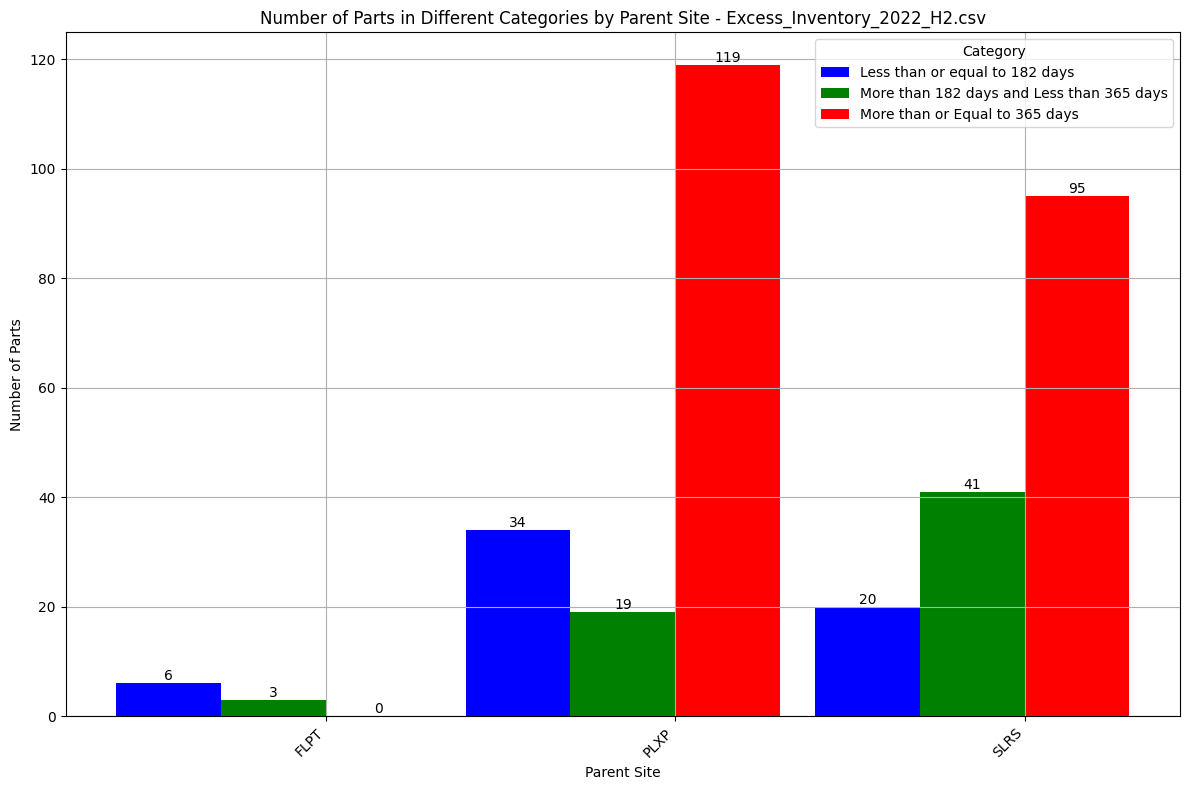

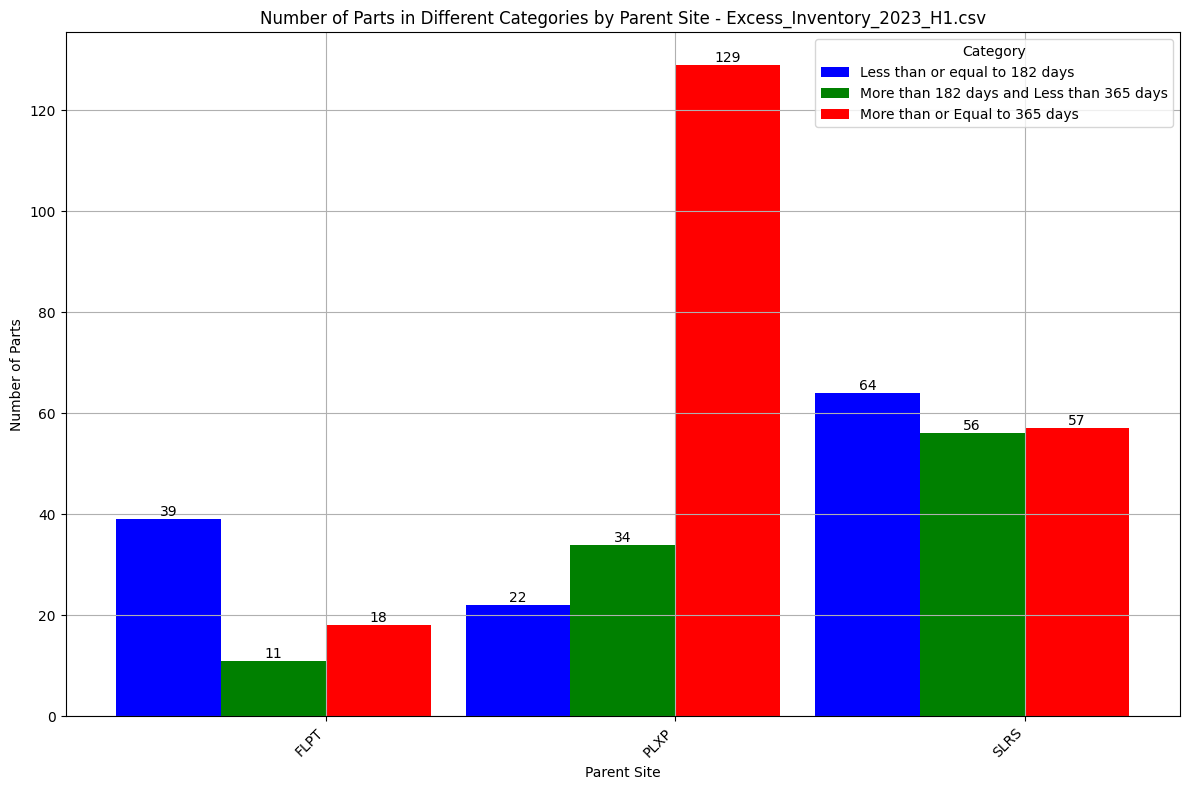

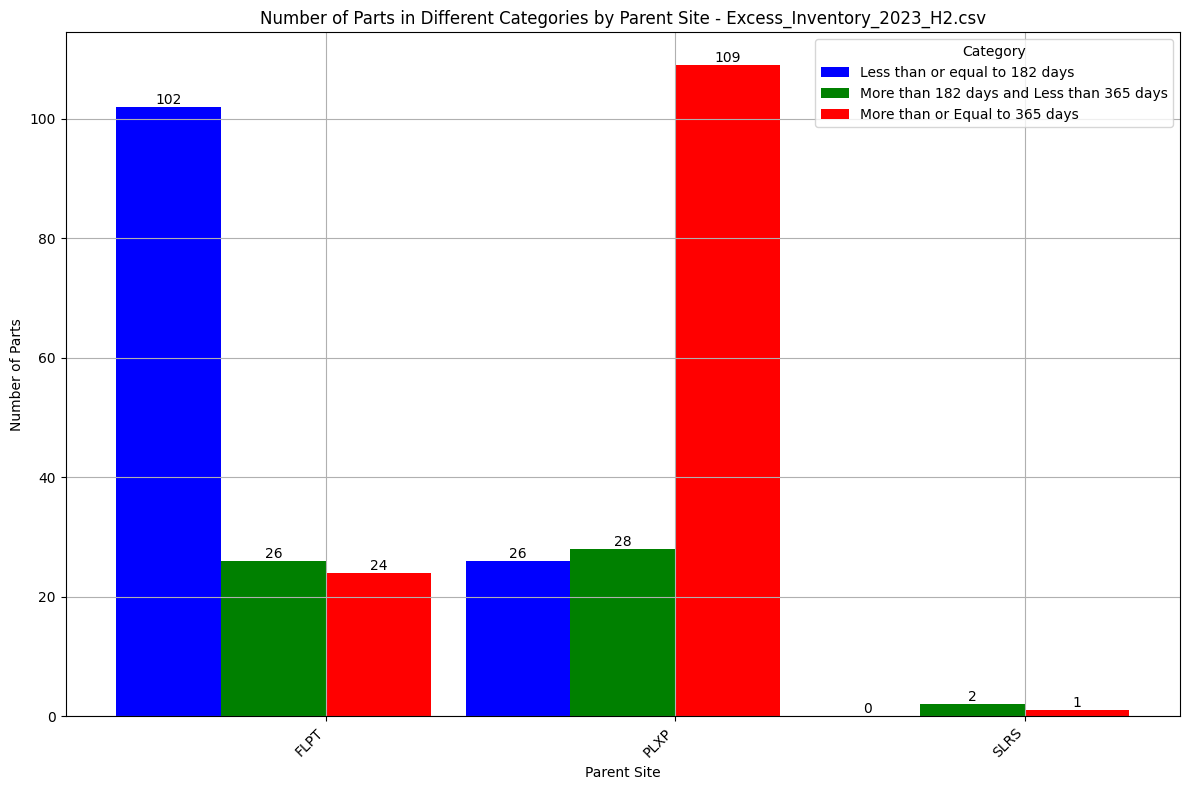

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths for all the monthly files
filepaths = [
    '/content/drive/My Drive/Project Raw Data/New_Output/Excess_Inventory_2022_H2.csv',
    '/content/drive/My Drive/Project Raw Data/New_Output/Excess_Inventory_2023_H1.csv',
    '/content/drive/My Drive/Project Raw Data/New_Output/Excess_Inventory_2023_H2.csv'
]

# Loop over each monthly file
for filepath in filepaths:
    # Read the monthly file
    monthly_df = pd.read_csv(filepath)

    # Convert "New LT (days)" column to timedelta data type
    monthly_df['LT (days)'] = pd.to_timedelta(monthly_df['LT (days)'])

    # Convert timedelta to numerical values representing days
    monthly_df['LT (days)'] = monthly_df['LT (days)'].dt.days

    # Define the bins and labels for categorizing "New LT (days)"
    bins = [-float('inf'), 182, 365, float('inf')]
    labels = ['Less than or equal to 182 days',
              'More than 182 days and Less than 365 days',
              'More than or Equal to 365 days']

    # Categorize the parts based on "New LT (days)"
    monthly_df['Category'] = pd.cut(monthly_df['LT (days)'], bins=bins, labels=labels)

    # Group by either "Site" or "Parent site" and count the number of parts in each category
    grouped_df = monthly_df.groupby(['Site', 'Category']).size().unstack(fill_value=0)

    # Plotting
    width = 0.3  # Width of each bar
    x = range(len(grouped_df))
    colors = ['b', 'g', 'r']  # Colors for each category

    fig, ax = plt.subplots(figsize=(12, 8))
    for i, col in enumerate(grouped_df.columns):
        bars = ax.bar([pos + i * width for pos in x], grouped_df[col], width, label=col, color=colors[i])
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')

    ax.set_title(f'Number of Parts in Different Categories by Parent Site - {filepath.split("/")[-1]}')
    ax.set_xlabel('Parent Site')
    ax.set_ylabel('Number of Parts')
    ax.set_xticks([pos + 1.5 * width for pos in x])  # Adjust positions of x-ticks
    ax.set_xticklabels(grouped_df.index, rotation=45, ha='right')
    ax.legend(title='Category')
    ax.grid(True)
    plt.tight_layout()

    # Save the plot as an image file
    output_filename = f'{filepath.split("/")[-1].split(".")[0]}_bar_graph.png'
    plt.savefig(output_filename)

    # Show the plot
    plt.show()

In [ ]:
# Loop over each monthly file
for filepath in filepaths:
    # Read the monthly file
    monthly_df = pd.read_csv(filepath)

    # Group by Site and calculate the sum of Potential Excess Inventory and Total Potential Excess Inventory ($)
    grouped_df = monthly_df.groupby('Site').agg({'Potential_Excess_Inventory': 'sum', 'Total Potential Excess Inventory($)': 'sum'})

    # Create a DataFrame from the grouped data
    data = pd.DataFrame({
        'Site': grouped_df.index,
        'Potential Excess Inventory': grouped_df['Potential_Excess_Inventory'],
        'Total Potential Excess Inventory ($)': grouped_df['Total Potential Excess Inventory($)']
    })

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))

    # Calculate the width for each bar
    bar_width = 0.35
    index = np.arange(len(data['Site']))

    # Plot Potential Excess Inventory
    ax.bar(index, data['Potential Excess Inventory'], bar_width, color='b', label='Potential Excess Inventory')

    # Plot Total Potential Excess Inventory ($) next to Potential Excess Inventory
    ax.bar(index + bar_width, data['Total Potential Excess Inventory ($)'], bar_width, color='r', label='Total Potential Excess Inventory ($)')

    # Set labels, title, and legend
    ax.set_xlabel('Site')
    ax.set_ylabel('Inventory')
    ax.set_title(f'Potential Excess Inventory and Total Potential Excess Inventory ($) by Site - {filepath}')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(data['Site'], rotation=45, ha='right')
    ax.legend()

    # Set y-axis limits for each plot
    ax.set_ylim(0, max(data['Potential Excess Inventory']) * 1.1)  # Adjusted for buffer space
    ax2 = ax.twinx()
    ax2.set_ylim(0, max(data['Total Potential Excess Inventory ($)']) * 1.1)  # Adjusted for buffer space

    # Show the plot
    plt.tight_layout()
    plt.show()

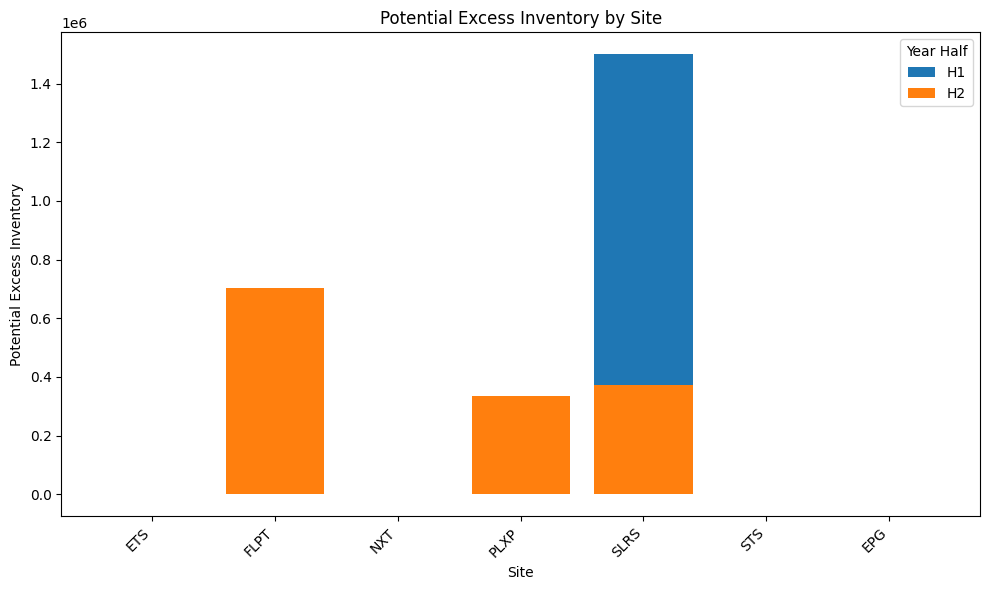

In [ ]:
# Initialize an empty DataFrame to store the results
result_df = pd.DataFrame()

# Process each file separately
for filepath in filepaths:
    # Read the file
    df = pd.read_csv(filepath)

    # Calculate the sum of Potential_Excess_Inventory for each site
    site_potential_excess = df.groupby('Parent site')['Potential_Excess_Inventory'].sum().reset_index()

    # Extract the year and half from the file name
    year_half = filepath.split('_')[-1].split('.')[0]

    # Create a new column to store the year and half information
    site_potential_excess['Year_Half'] = year_half

    # Append the results to the main DataFrame
    result_df = pd.concat([result_df, site_potential_excess], ignore_index=True)

# Plotting
plt.figure(figsize=(10, 6))
for year_half, group in result_df.groupby('Year_Half'):
    plt.bar(group['Parent site'], group['Potential_Excess_Inventory'], label=year_half)

plt.title('Potential Excess Inventory by Site')
plt.xlabel('Site')
plt.ylabel('Potential Excess Inventory')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Year Half')
plt.tight_layout()
plt.show()

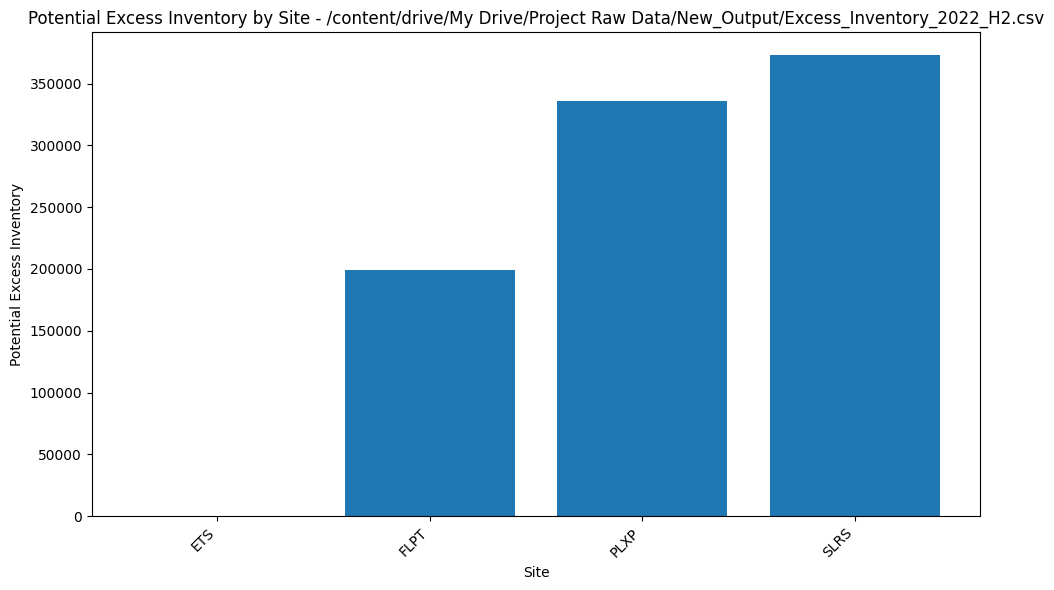

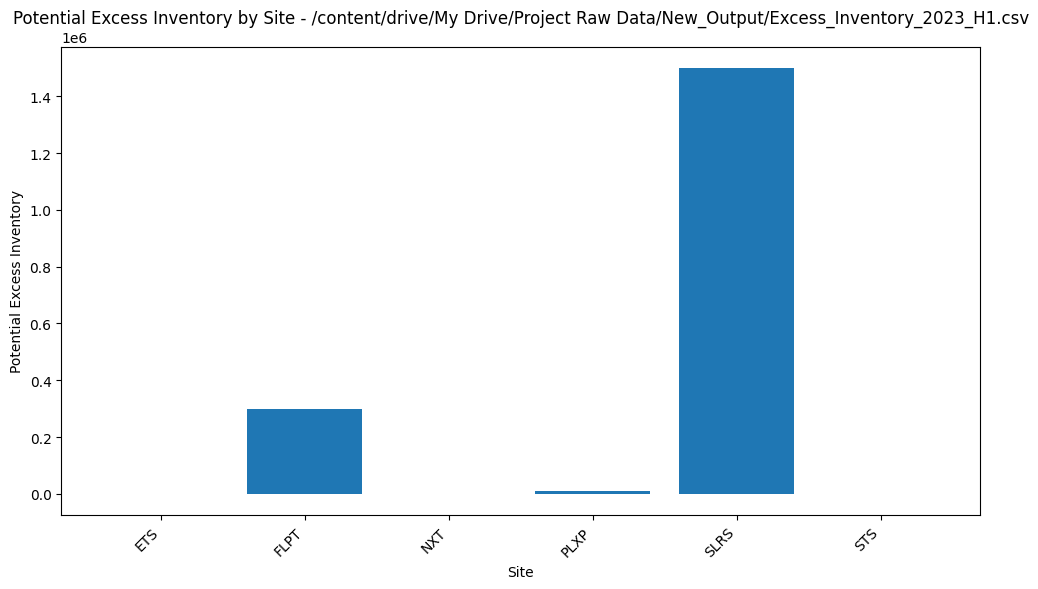

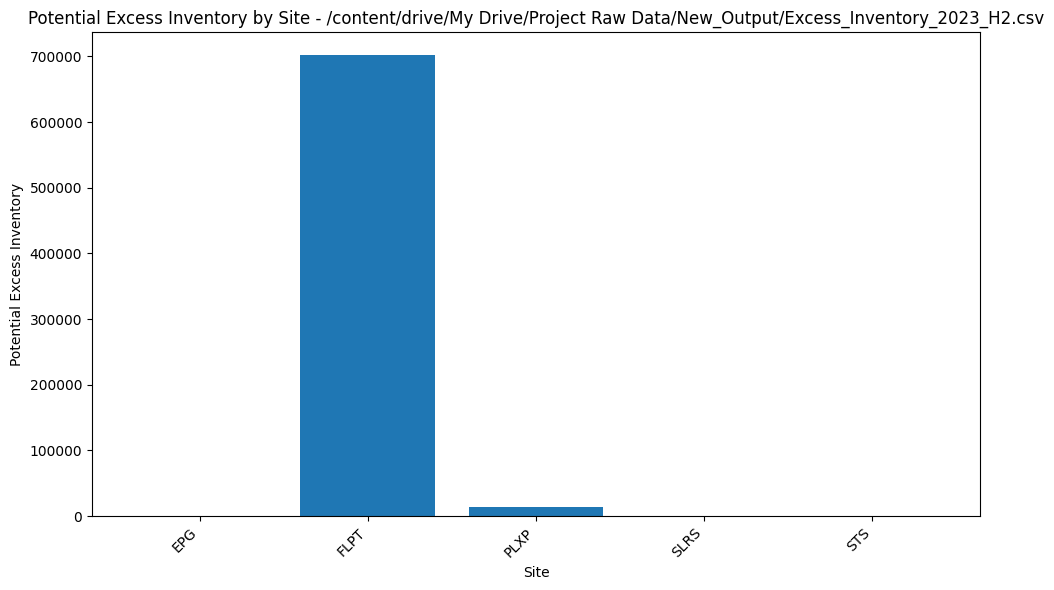

In [ ]:
# Process each file separately
for filepath in filepaths:
    # Read the file
    df = pd.read_csv(filepath)

    # Calculate the sum of Potential_Excess_Inventory for each site
    site_potential_excess = df.groupby('Parent site')['Potential_Excess_Inventory'].sum().reset_index()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(site_potential_excess['Parent site'], site_potential_excess['Potential_Excess_Inventory'])
    plt.title(f'Potential Excess Inventory by Site - {filepath}')
    plt.xlabel('Site')
    plt.ylabel('Potential Excess Inventory')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

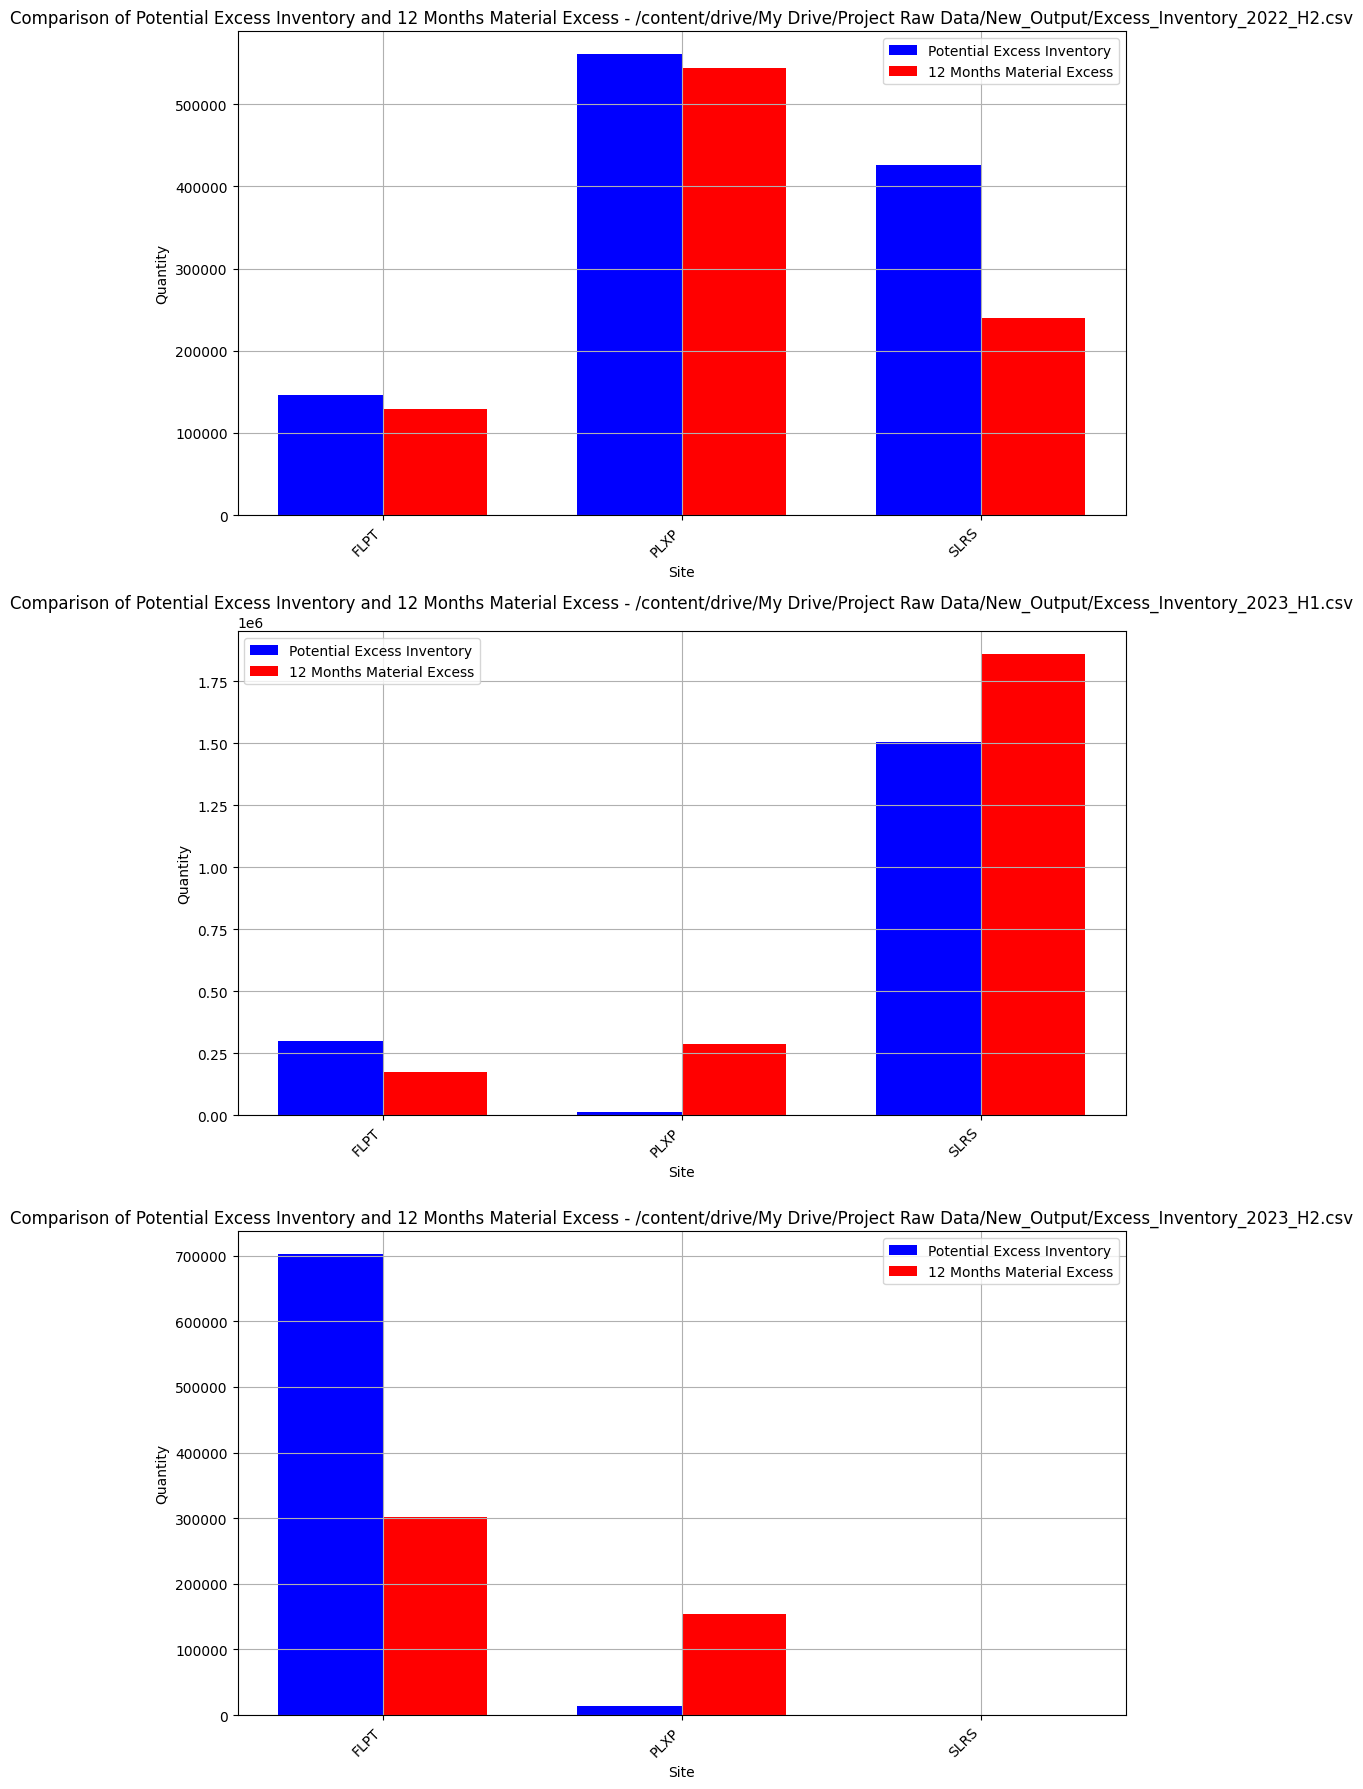

In [ ]:
# Initialize a figure and axis object
fig, axs = plt.subplots(len(filepaths), 1, figsize=(10, 6 * len(filepaths)))

# Process each file separately
for i, filepath in enumerate(filepaths):
    # Read the file
    df = pd.read_csv(filepath)

    # Calculate the sum of Potential_Excess_Inventory for each site
    site_potential_excess = df.groupby('Site')['Potential_Excess_Inventory'].sum().reset_index()

    # Calculate the sum of 12 months material excess for each site
    site_12_months_excess = df.groupby('Site')['12 months materials excess'].sum().reset_index()

    # Merge the dataframes on 'Parent site'
    merged_df = pd.merge(site_potential_excess, site_12_months_excess, on='Site')

    # Plotting
    width = 0.35  # Width of the bars
    x = range(len(merged_df))
    axs[i].bar(x, merged_df['Potential_Excess_Inventory'], width, color='b', label='Potential Excess Inventory')
    axs[i].bar([pos + width for pos in x], merged_df['12 months materials excess'], width, color='r', label='12 Months Material Excess')
    axs[i].set_title(f'Comparison of Potential Excess Inventory and 12 Months Material Excess - {filepath}')
    axs[i].set_xlabel('Site')
    axs[i].set_ylabel('Quantity')
    axs[i].set_xticks([pos + width / 2 for pos in x])
    axs[i].set_xticklabels(merged_df['Site'], rotation=45, ha='right')
    axs[i].legend()
    axs[i].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Project Raw Data/New_Output/Excess_Inventory_2023_H2.csv')

df.tail()

,Request ID,Requested date,TER Part Number,Site,cum lt wks,Adjusted date,LT (days),New LT (days),New Adjusted date,Planned Demand,...,Quantity ordered,Potential_Excess_Inventory,12 months materials excess,PO Price,Total Potential Excess Inventory($),12 months materials excess ($),Parent site,Parent part,Month,Year
313,PLEX-10449,2023-12-06,HAR1935G,PLXP,23.8,2024-11-03,333 days 04:48:00,333 days 04:48:00,2024-11-03,28.0,...,50,38.0,36,30.1,1144.2,1084.0,PLXP,AST5597G,12,2023
314,PLEX-10459,2023-12-07,PCB1521-R1,PLXP,12.6,2024-05-31,176 days 09:36:00,182 days 00:00:00,2024-06-06,202.0,...,150,28.0,55,108.0,3024.6,5941.1,PLXP,ASC1521,12,2023
315,PLEX-10469,2023-12-12,PCB2761-R2,PLXP,5.6,2024-02-28,78 days 09:36:00,182 days 00:00:00,2024-06-11,0.0,...,20,26.0,18,159.9,4157.7,2878.4,NaN,NaN,12,2023
316,PLEX-10471,2023-12-12,PCB3031-R4,PLXP,17.8,2024-08-17,249 days 04:48:00,249 days 04:48:00,2024-08-17,71.0,...,40,31.0,28,159.2,4936.8,4459.0,PLXP,AST3031,12,2023
317,PLEX-10470,2023-12-12,PCB7193G-R2,PLXP,7.0,2024-03-19,98 days 00:00:00,182 days 00:00:00,2024-06-11,22.0,...,25,3.0,6,133.1,399.2,798.4,PLXP,ASM7193G,12,2023


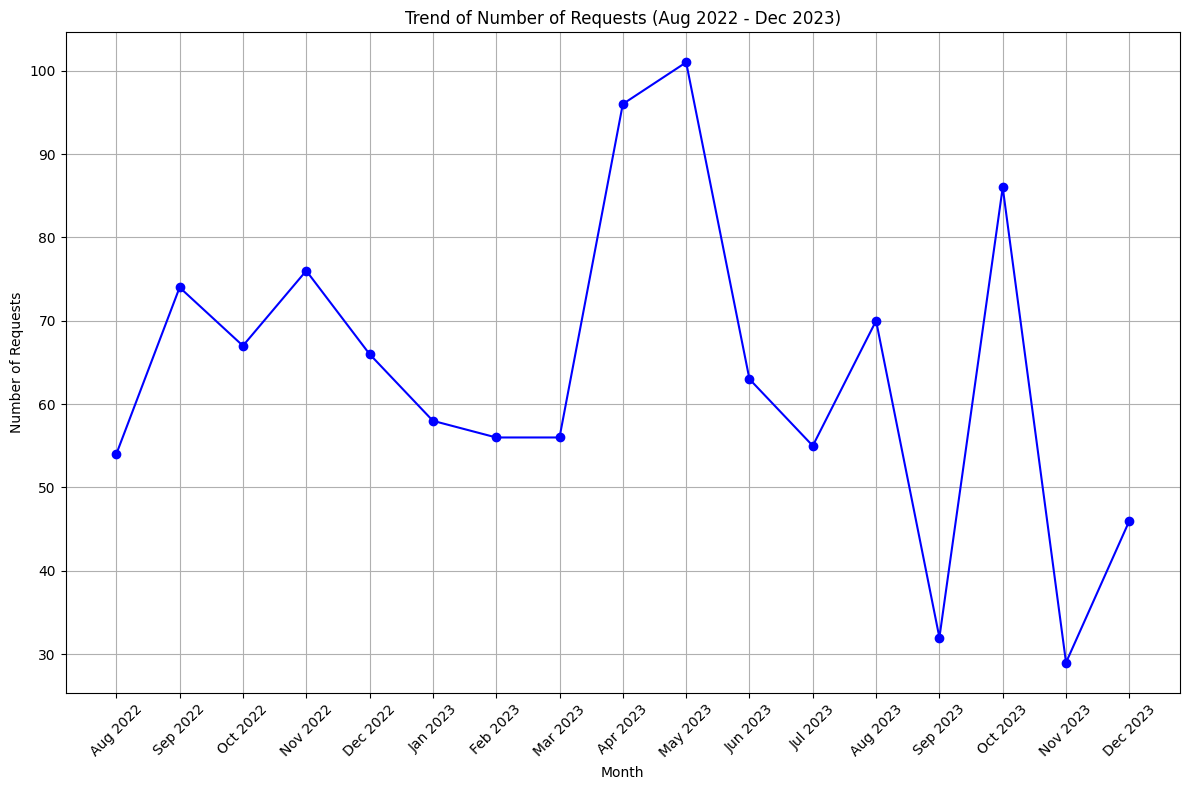

In [ ]:
# Initialize an empty list to store the dataframes from all files
all_dfs = []

# Loop over each monthly file
for filepath in filepaths:
    # Read the file
    df = pd.read_csv(filepath)

    # Convert date columns to datetime objects
    df['Requested date'] = pd.to_datetime(df['Requested date'])

    # Append the dataframe to the list
    all_dfs.append(df)

# Concatenate all dataframes into a single dataframe
combined_df = pd.concat(all_dfs, ignore_index=True)

# Filter and convert "Requested date" to datetime format
combined_df['Requested date'] = pd.to_datetime(combined_df['Requested date'])

# Group the data by month and count the number of requests for each month
monthly_requests = combined_df.groupby(combined_df['Requested date'].dt.to_period('M')).size()

# Generate a range of periods from August 2022 to December 2023
all_months = pd.period_range(start='2022-08', end='2023-12', freq='M')

# Convert PeriodIndex to strings representing month and year
all_months_str = [month.strftime('%b %Y') for month in all_months]

# Plot the line graph
plt.figure(figsize=(12, 8))
plt.plot(all_months_str, monthly_requests, marker='o', color='b')
plt.title('Trend of Number of Requests (Aug 2022 - Dec 2023)')
plt.xlabel('Month')
plt.ylabel('Number of Requests')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

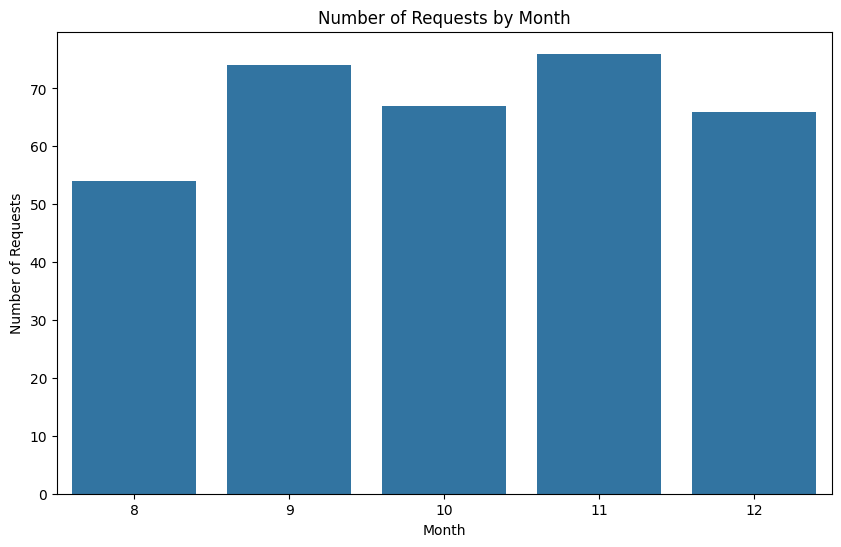

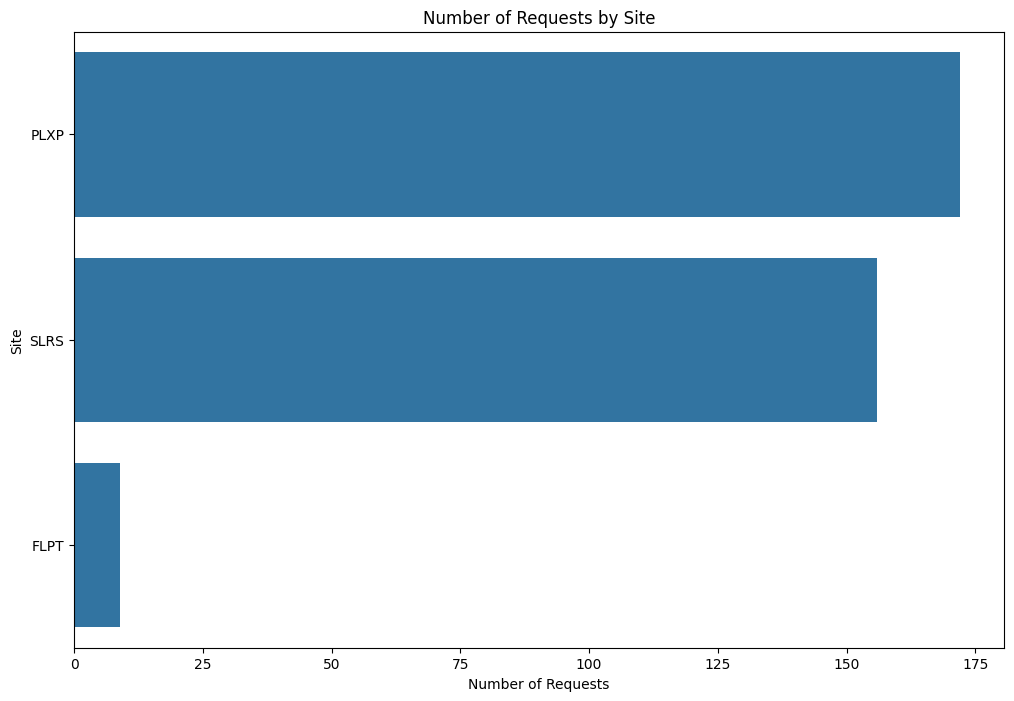

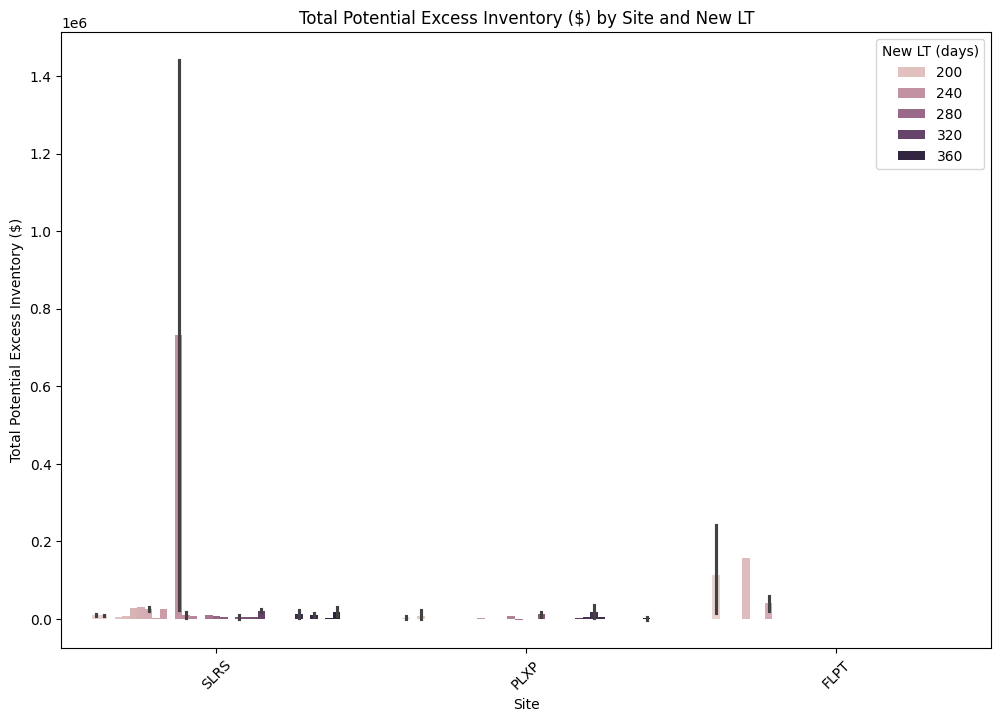

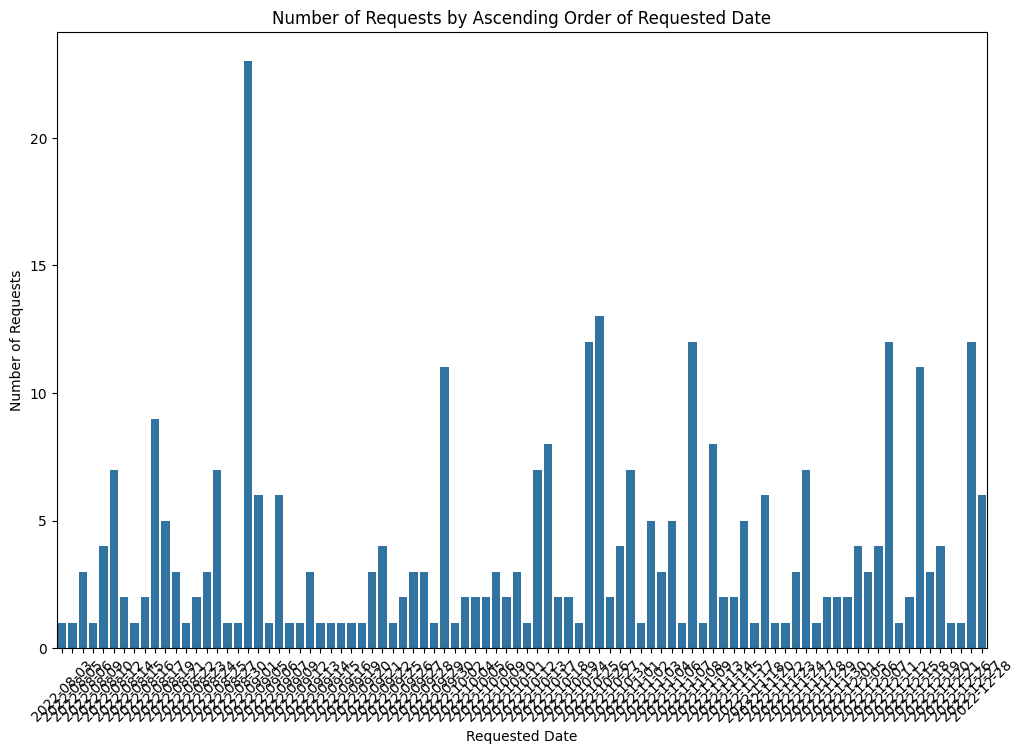

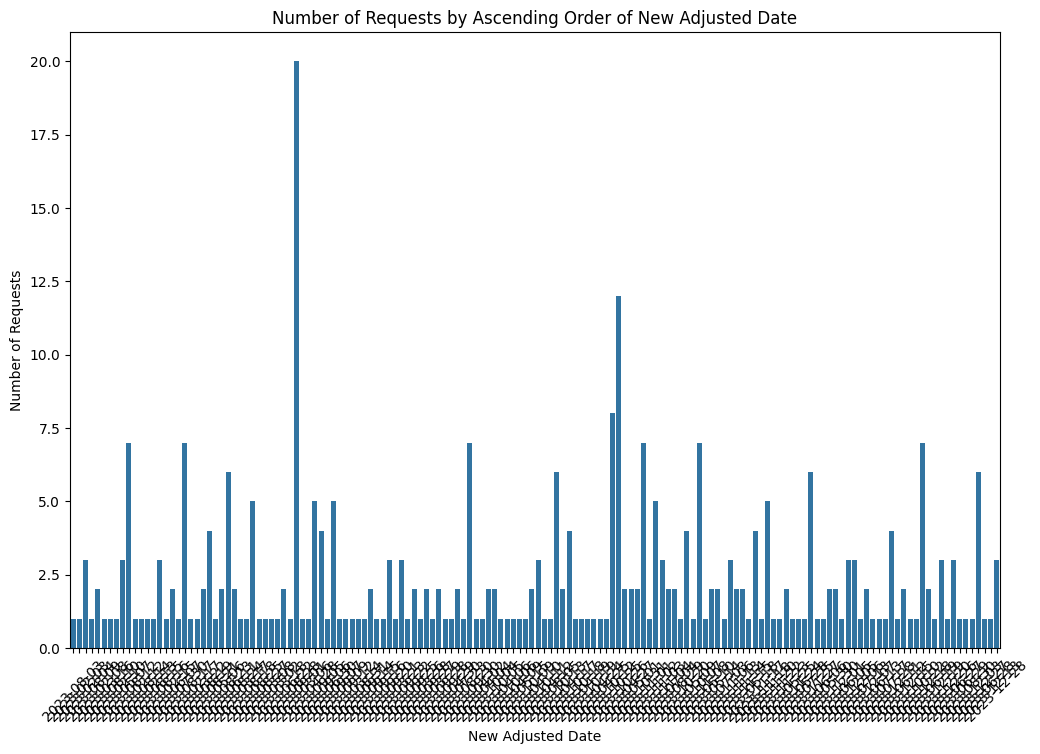

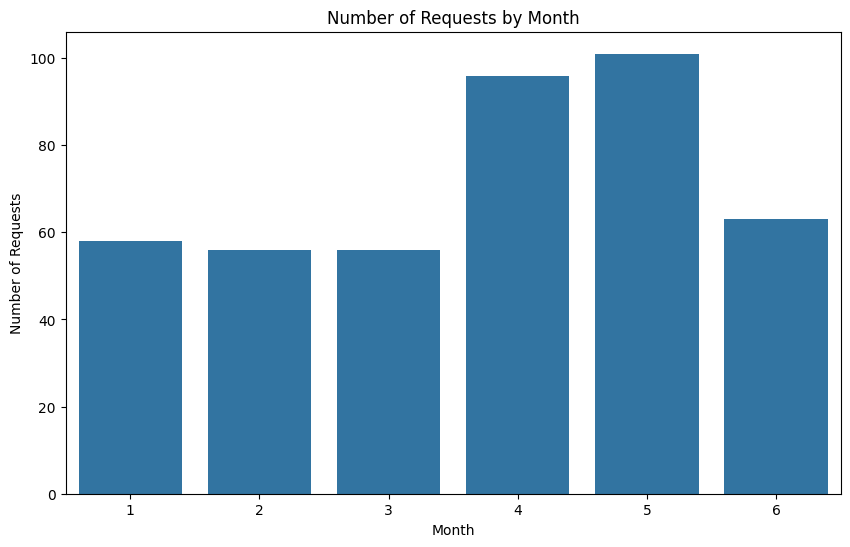

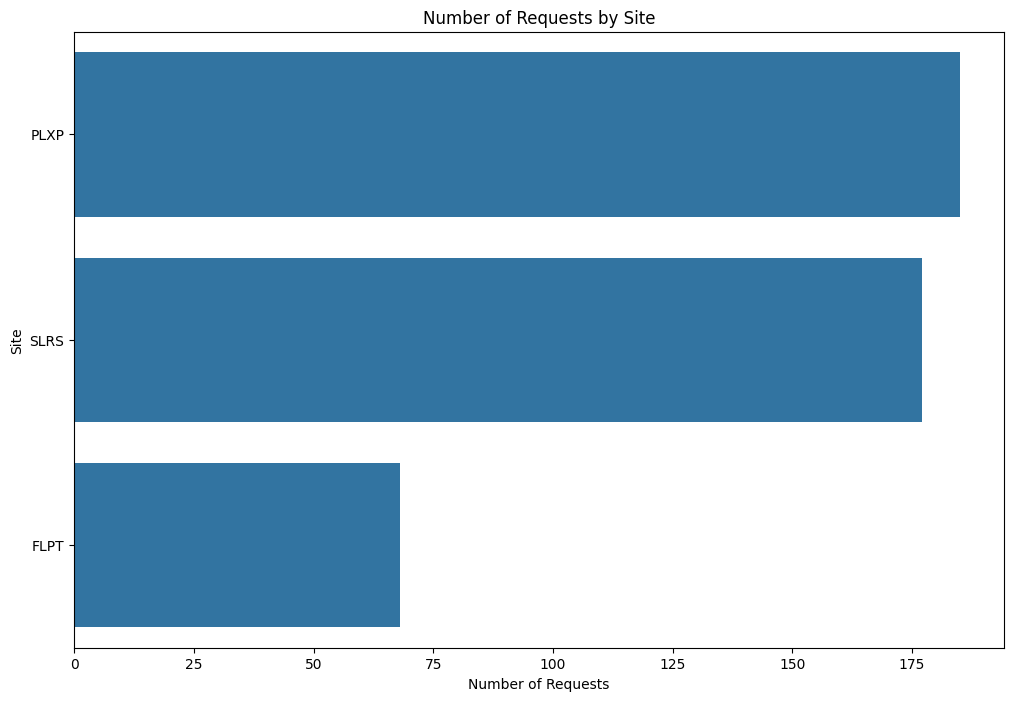

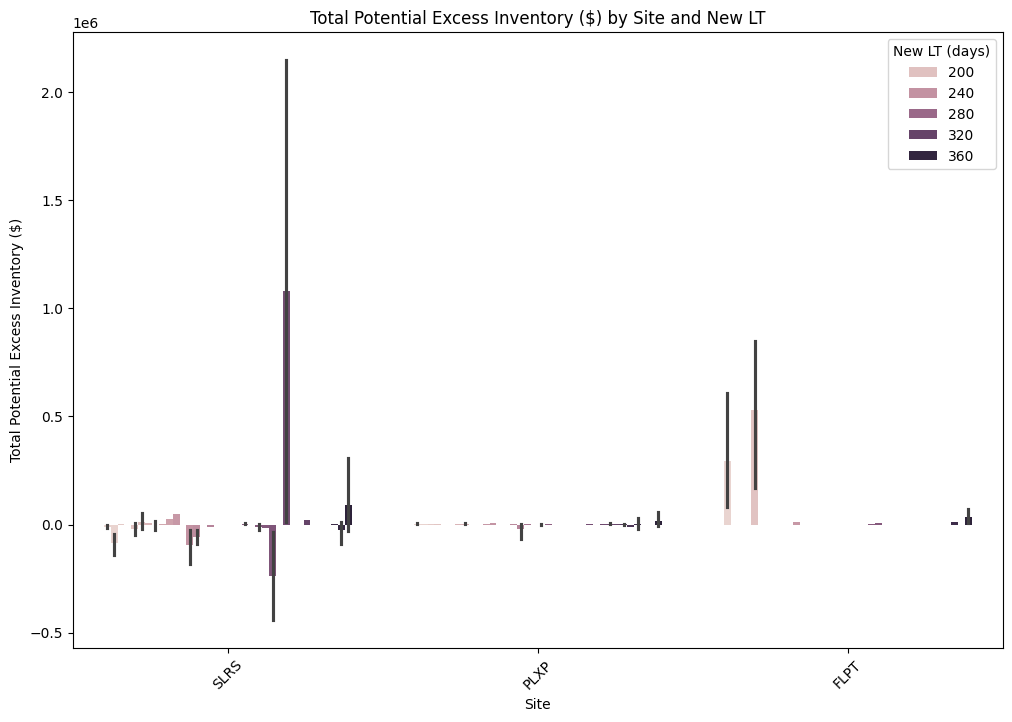

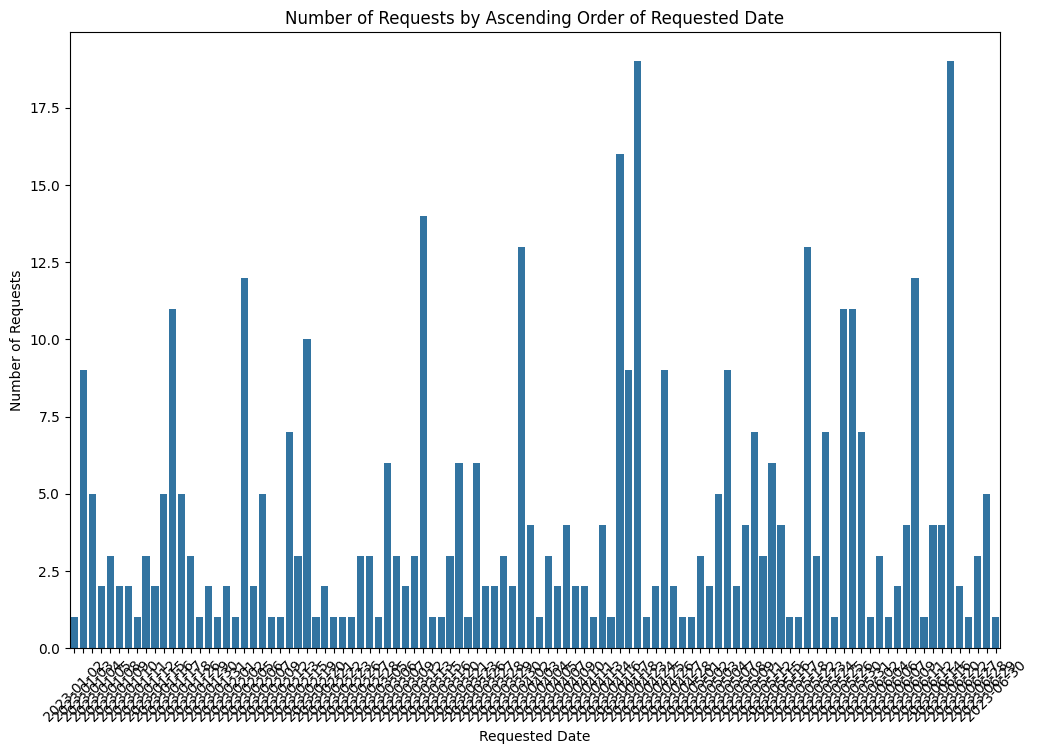

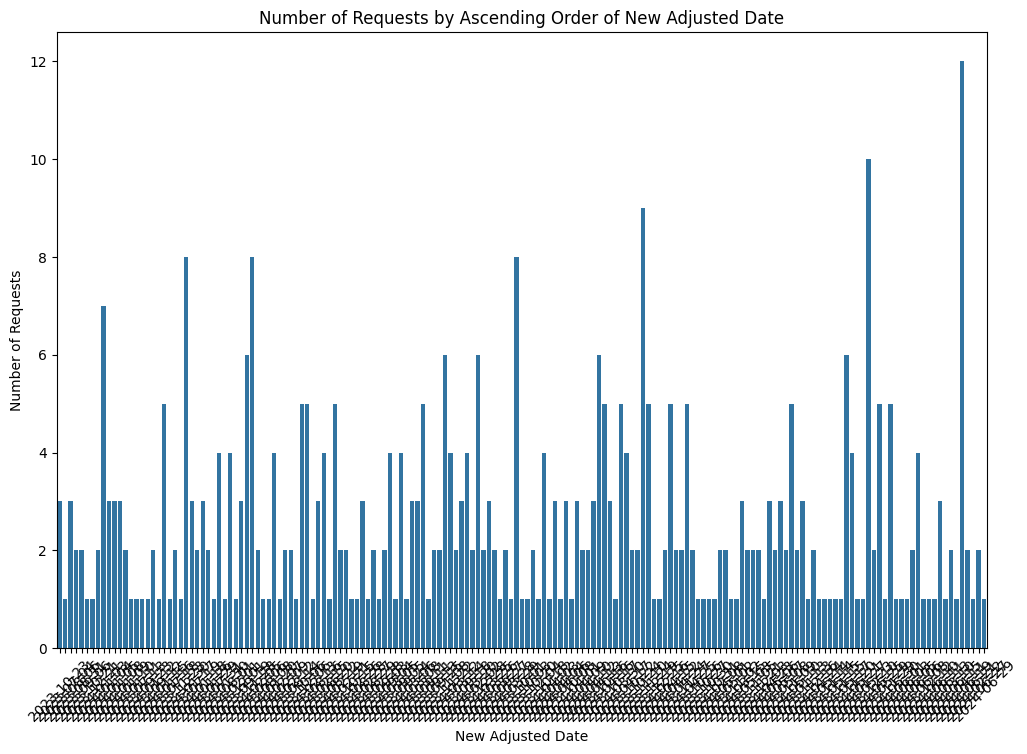

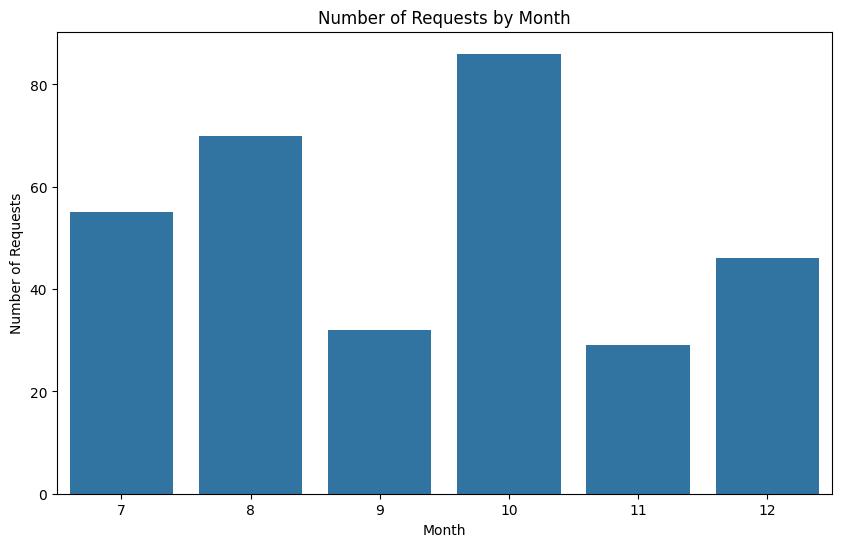

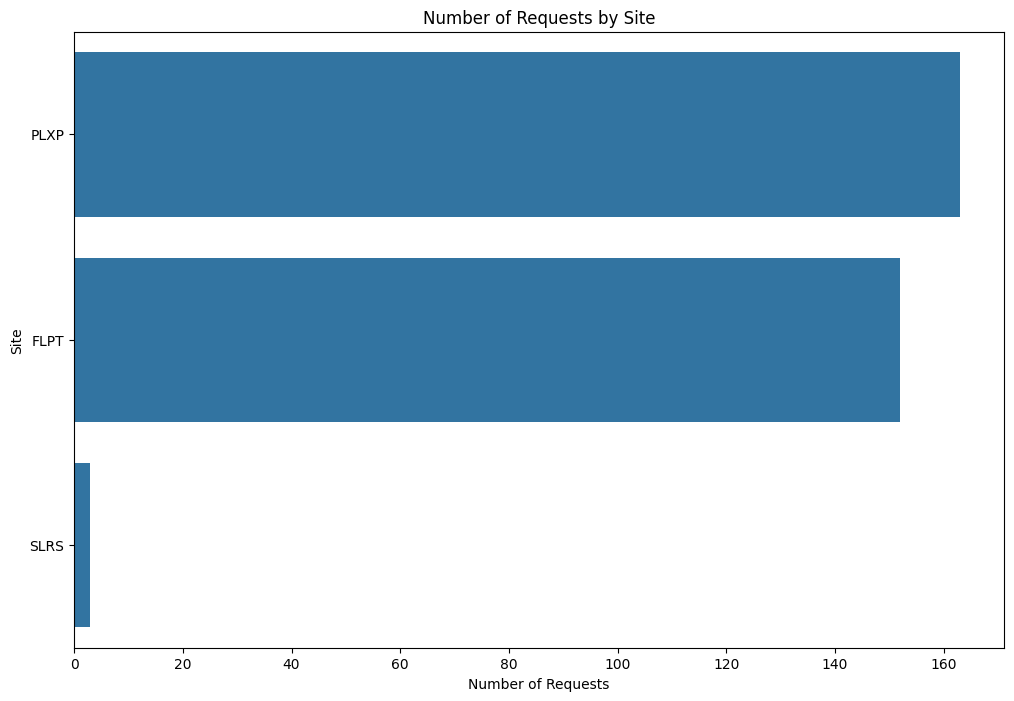

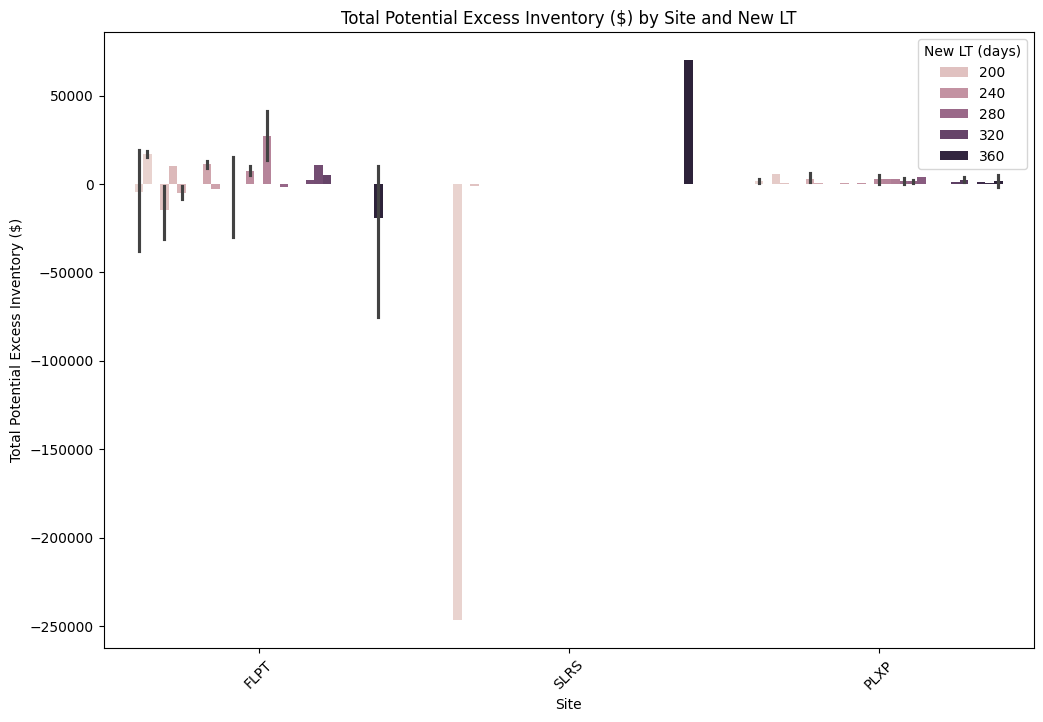

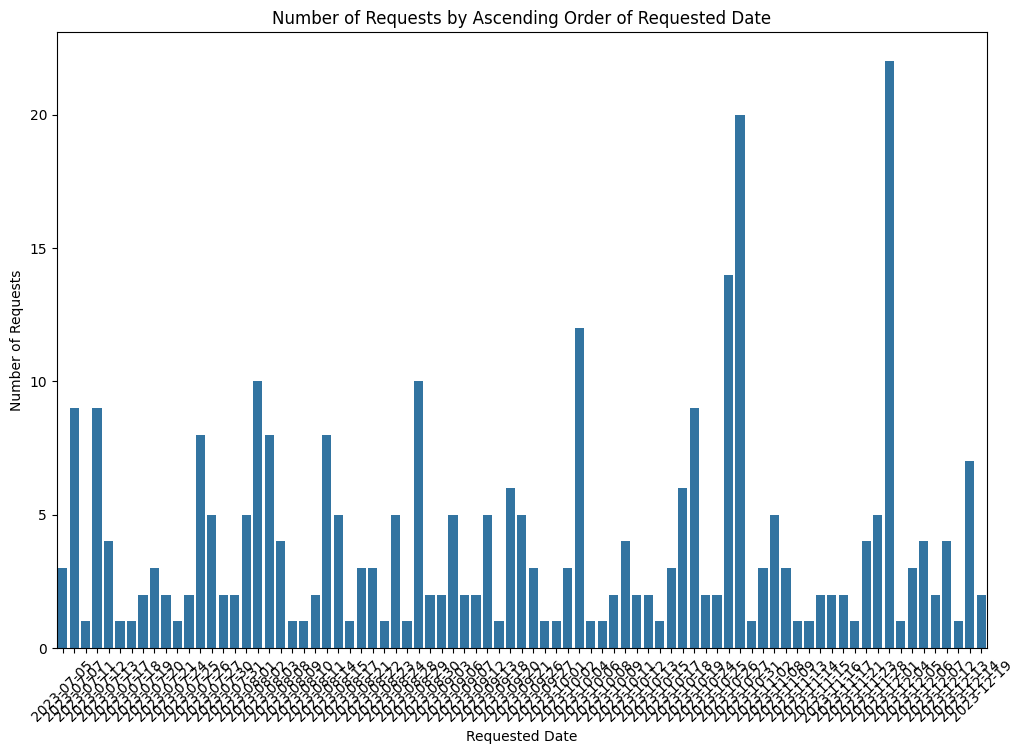

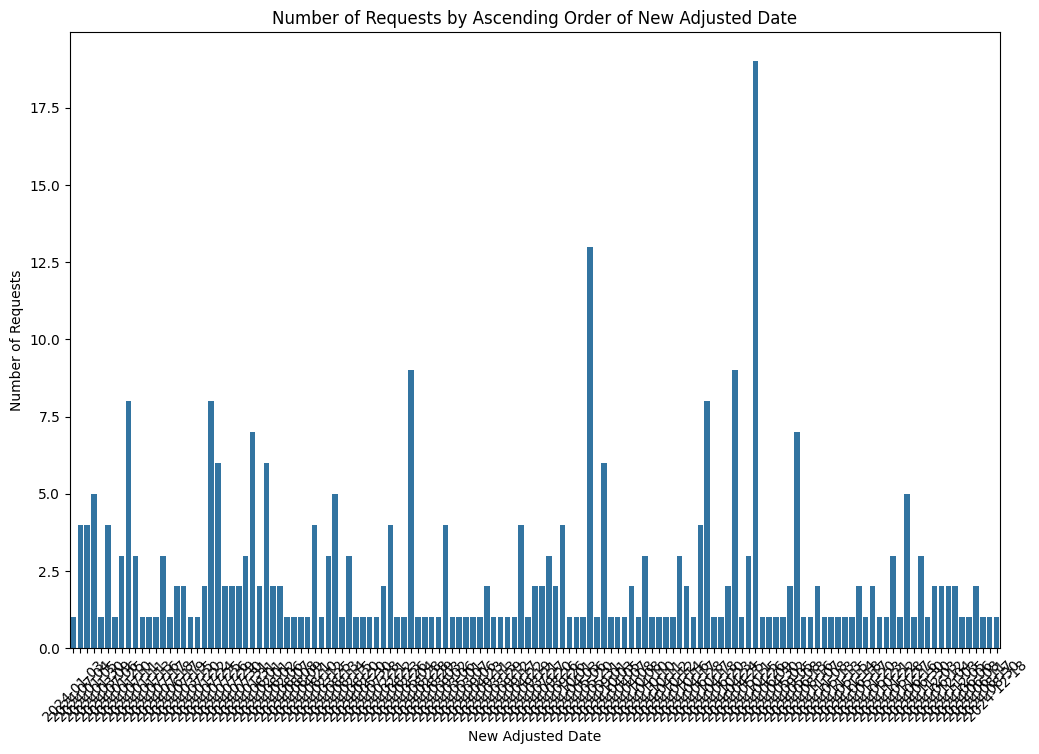

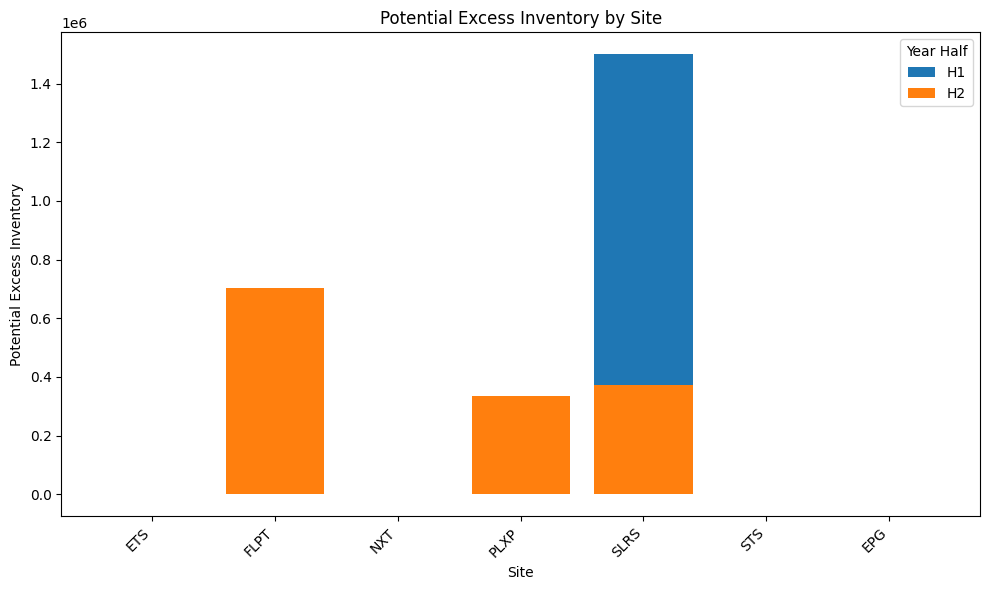

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File paths for all the monthly files
filepaths = [
    '/content/drive/My Drive/Project Raw Data/New_Output/Excess_Inventory_2022_H2.csv',
    '/content/drive/My Drive/Project Raw Data/New_Output/Excess_Inventory_2023_H1.csv',
    '/content/drive/My Drive/Project Raw Data/New_Output/Excess_Inventory_2023_H2.csv'
]

# Initialize an empty DataFrame to store the results
result_df = pd.DataFrame()

# Loop over each monthly file
for filepath in filepaths:
    # Read the file
    df = pd.read_csv(filepath)

    # Convert date columns to datetime objects
    df['Requested date'] = pd.to_datetime(df['Requested date'])
    df['New Adjusted date'] = pd.to_datetime(df['New Adjusted date'])

    # Visualization of number of requests along the month
    plt.figure(figsize=(10, 6))
    sns.countplot(x=df['Requested date'].dt.month)
    plt.title('Number of Requests by Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Requests')
    plt.show()

    # Visualization of number of requests along the site
    plt.figure(figsize=(12, 8))
    sns.countplot(y=df['Site'], order=df['Site'].value_counts().index)
    plt.title('Number of Requests by Site')
    plt.xlabel('Number of Requests')
    plt.ylabel('Site')
    plt.show()

    # Convert "New LT (days)" column to timedelta data type
    df['New LT (days)'] = pd.to_timedelta(df['New LT (days)'])

    # Convert timedelta to numerical values representing days
    df['New LT (days)'] = df['New LT (days)'].dt.days

    # Visualization of Total Potential Excess Inventory ($) with respect to Site and New LT
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Site', y='Total Potential Excess Inventory($)', hue='New LT (days)', data=df)
    plt.title('Total Potential Excess Inventory ($) by Site and New LT')
    plt.xlabel('Site')
    plt.ylabel('Total Potential Excess Inventory ($)')
    plt.xticks(rotation=45)
    plt.legend(title='New LT (days)')
    plt.show()

    # Visualization of Requests along ascending order of Requested date & New Adjusted date
    df_sorted_date = df.sort_values(by=['Requested date', 'New Adjusted date'])

    plt.figure(figsize=(12, 8))
    sns.countplot(x=df_sorted_date['Requested date'].dt.strftime('%Y-%m-%d'))
    plt.title('Number of Requests by Ascending Order of Requested Date')
    plt.xlabel('Requested Date')
    plt.ylabel('Number of Requests')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.countplot(x=df_sorted_date['New Adjusted date'].dt.strftime('%Y-%m-%d'))
    plt.title('Number of Requests by Ascending Order of New Adjusted Date')
    plt.xlabel('New Adjusted Date')
    plt.ylabel('Number of Requests')
    plt.xticks(rotation=45)
    plt.show()

    # Calculate the sum of Potential_Excess_Inventory for each site
    site_potential_excess = df.groupby('Parent site')['Potential_Excess_Inventory'].sum().reset_index()

    # Extract the year and half from the file name
    year_half = filepath.split('_')[-1].split('.')[0]

    # Create a new column to store the year and half information
    site_potential_excess['Year_Half'] = year_half

    # Append the results to the main DataFrame
    result_df = pd.concat([result_df, site_potential_excess], ignore_index=True)

# Plotting Total Potential Excess Inventory by Site for each year half
plt.figure(figsize=(10, 6))
for year_half, group in result_df.groupby('Year_Half'):
    plt.bar(group['Parent site'], group['Potential_Excess_Inventory'], label=year_half)

plt.title('Potential Excess Inventory by Site')
plt.xlabel('Site')
plt.ylabel('Potential Excess Inventory')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Year Half')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import os

# List to store data from each file
demand_data = []

# Directory containing the demand files
demand_directory = '/content/drive/My Drive/Project Raw Data/Demand/'

# Loop over each demand file
for filename in os.listdir(demand_directory):
    if filename.endswith('.xlsx'):  # Ensure it's an Excel file
        filepath = os.path.join(demand_directory, filename)

        # Read the demand data from the Excel file
        demand_df = pd.read_excel(filepath)

        # Convert 'Due Date' column to datetime format, handling non-standard values
        demand_df['Due Date'] = pd.to_datetime(demand_df['Due Date'], errors='coerce')

        # Drop rows with NaN values in the 'Due Date' column
        demand_df = demand_df.dropna(subset=['Due Date'])

        # Perform checks and append results to the list
        unique_ter_part_numbers = demand_df['TER Part Number'].nunique()
        unique_sites = demand_df['Site'].nunique()
        min_due_date = demand_df['Due Date'].min()
        max_due_date = demand_df['Due Date'].max()
        unique_parent_parts = demand_df['Parent part'].nunique()
        unique_parent_sites = demand_df['Parent site'].nunique()

        demand_data.append({
            'File': filename,
            'Unique TER Part Numbers': unique_ter_part_numbers,
            'Unique Sites': unique_sites,
            'Min Due Date': min_due_date,
            'Max Due Date': max_due_date,
            'Unique Parent Parts': unique_parent_parts,
            'Unique Parent Sites': unique_parent_sites
        })

# Create a DataFrame from the collected data
demand_summary_df = pd.DataFrame(demand_data)

# Display the summary DataFrame
print(demand_summary_df)

<ipython-input-7-1574767b28a9>:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  demand_df['Due Date'] = pd.to_datetime(demand_df['Due Date'], errors='coerce')
<ipython-input-7-1574767b28a9>:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  demand_df['Due Date'] = pd.to_datetime(demand_df['Due Date'], errors='coerce')
<ipython-input-7-1574767b28a9>:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  demand_df['Due Date'] = pd.to_datetime(demand_df['Due Date'], errors='coerce')
<ipython-input-7-1574767b28a9>:19: UserWarning: Could not infer format, so each element will be pars

                File  Unique TER Part Numbers  Unique Sites Min Due Date  \
0   2211 Demand.xlsx                     1003             3   2021-10-13   
1   2301 Demand.xlsx                      997             3   2022-01-13   
2   2212 Demand.xlsx                      995             3   2021-11-12   
3   2302 Demand.xlsx                      994             3   2022-01-13   
4   2303 Demand.xlsx                      993             3   2022-08-18   
5   2304 Demand.xlsx                      993             3   2022-08-18   
6   2305 Demand.xlsx                      985             3   2022-05-22   
7   2306 Demand.xlsx                      979             3   2022-05-22   
8   2307 Demand.xlsx                      968             3   2022-09-02   
9   2309 Demand.xlsx                      933             3   2022-09-02   
10  2310 Demand.xlsx                      902             3   2022-11-23   
11  2311 Demand.xlsx                      903             3   2022-12-06   
12  2312 Dem

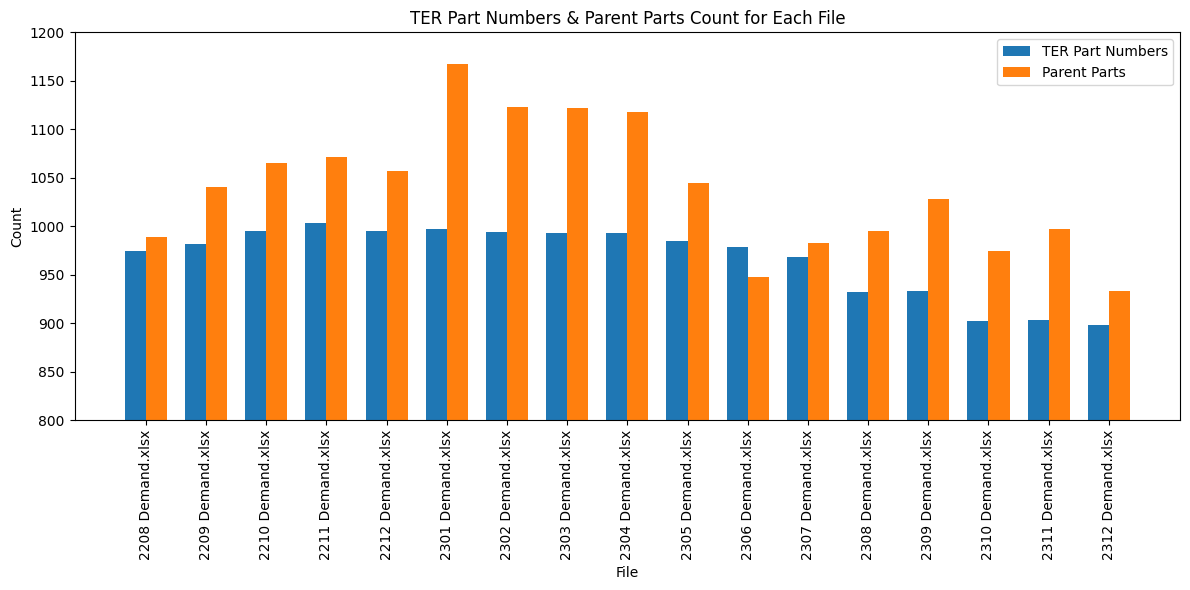

In [ ]:
import numpy as np

# Define the width of each bar
bar_width = 0.35

# Create an array of indices for positioning bars
indices = np.arange(len(demand_summary_df_sorted))

# Plotting the side-by-side bar plot
plt.figure(figsize=(12, 6))

# Plotting TER Part Numbers
plt.bar(indices - bar_width/2, demand_summary_df_sorted['Unique TER Part Numbers'], bar_width, label='TER Part Numbers')

# Plotting Parent Parts
plt.bar(indices + bar_width/2, demand_summary_df_sorted['Unique Parent Parts'], bar_width, label='Parent Parts')

# Adding labels and title
plt.xlabel('File')
plt.ylabel('Count')
plt.title('TER Part Numbers & Parent Parts Count for Each File')
plt.xticks(indices, demand_summary_df_sorted['File'], rotation=90)
plt.legend()
plt.tight_layout()

# Set y-axis range
plt.ylim(800, 1200)

plt.show()

File 'cleaned_2308 Part data.xlsx' does not contain 'TER Part Number' column. Skipping...
File 'cleaned_2302 Part data.xlsx' does not contain 'TER Part Number' column. Skipping...
File 'cleaned_2311 Part data.xlsx' does not contain 'TER Part Number' column. Skipping...
File 'cleaned_2210 Part data.xlsx' does not contain 'TER Part Number' column. Skipping...
File 'cleaned_2309 Part data.xlsx' does not contain 'TER Part Number' column. Skipping...
File 'cleaned_2208 Part data.xlsx' does not contain 'TER Part Number' column. Skipping...
File 'cleaned_2306 Part data.xlsx' does not contain 'TER Part Number' column. Skipping...
File 'cleaned_2305 Part data.xlsx' does not contain 'TER Part Number' column. Skipping...
File 'cleaned_2310 Part data.xlsx' does not contain 'TER Part Number' column. Skipping...
File 'cleaned_2303 Part data.xlsx' does not contain 'TER Part Number' column. Skipping...
File 'cleaned_2304 Part data.xlsx' does not contain 'TER Part Number' column. Skipping...
File 'clea

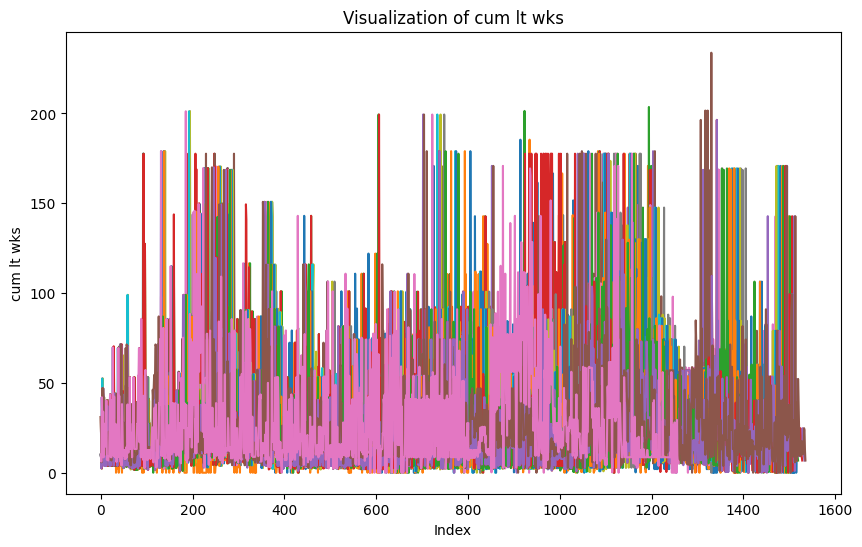

In [ ]:
# List to store data from each file
lead_time_data = []

# Directory containing the lead time files
lead_time_directory = '/content/drive/My Drive/Project Raw Data/LT Data/'

# Loop over each lead time file
for filename in os.listdir(lead_time_directory):
    if filename.endswith('.xlsx'):  # Ensure it's an Excel file
        filepath = os.path.join(lead_time_directory, filename)

        # Read the lead time data from the Excel file
        try:
            lead_time_df = pd.read_excel(filepath)
        except Exception as e:
            print(f"Error reading file '{filename}': {e}")
            continue

        # Perform checks and append results to the list
        if 'TER Part Number' not in lead_time_df.columns:
            print(f"File '{filename}' does not contain 'TER Part Number' column. Skipping...")
            continue

        unique_ter_part_numbers = lead_time_df['TER Part Number'].nunique()
        unique_sites = lead_time_df['Site'].nunique()
        visualization_data = lead_time_df['cum lt wks']  # Data for visualization

        lead_time_data.append({
            'File': filename,
            'Unique TER Part Numbers': unique_ter_part_numbers,
            'Unique Sites': unique_sites,
            'Visualization Data': visualization_data
        })

# Create a DataFrame from the collected data
lead_time_summary_df = pd.DataFrame(lead_time_data)

# Display the summary DataFrame
print(lead_time_summary_df)

# Visualize the 'cum lt wks' data (example)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for data in lead_time_summary_df['Visualization Data']:
    plt.plot(data)
plt.xlabel('Index')
plt.ylabel('cum lt wks')
plt.title('Visualization of cum lt wks')
plt.show()

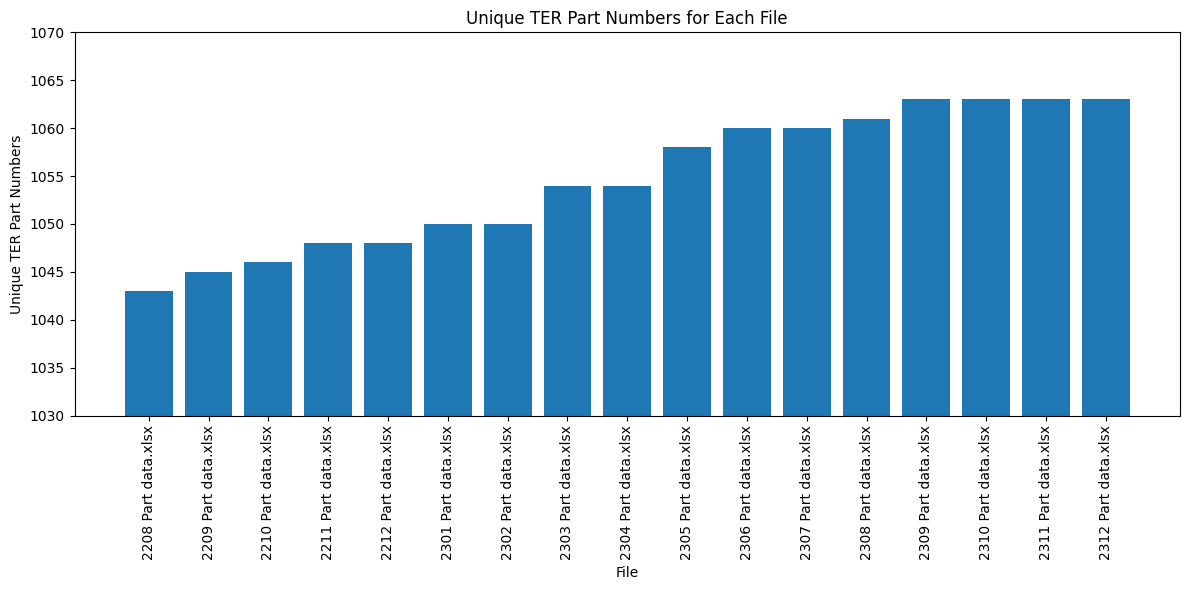

In [ ]:
import matplotlib.pyplot as plt

lead_time_summary_df_sorted = lead_time_summary_df.sort_values(by='File')

# Plot the TER Part Numbers
plt.figure(figsize=(12, 6))
plt.bar(lead_time_summary_df_sorted['File'], lead_time_summary_df_sorted['Unique TER Part Numbers'])
plt.xlabel('File')
plt.ylabel('Unique TER Part Numbers')
plt.title('Unique TER Part Numbers for Each File')
plt.xticks(rotation=90)
plt.ylim(1030, 1070)  # Set the y-axis range
plt.tight_layout()
plt.show()